# Project Description

**Project: customer-activity-prediction - supervised learning**

**Project Description**

The online store *“One Click”* sells a wide range of products: goods for children, household items, small home appliances, cosmetics, and even groceries. The company’s report for the previous period showed that customer activity has started to decline. Attracting new customers is no longer as effective, since most of the target audience is already aware of the store. A possible solution is to retain and increase the activity of existing customers. This can be achieved through personalized offers.

*“One Click”* is a modern company, so its management does not want to make decisions blindly—only based on data analysis and business modeling. The company has a small digital technology department, and you will take on the role of an intern in this department.

Thus, your team has been tasked with developing a solution that will allow personalized offers to be created for loyal customers in order to increase their purchasing activity.


**Research Objective**

* Identify the key factors driving the decline in purchasing activity and determine customer groups with different levels of risk and profitability.

* Build and compare classification models to predict the probability of a decrease in activity, and select the best model using the **ROC-AUC** metric.

* Segment customers based on predicted risks and profitability, determine priority segments for business action, and develop recommendations to increase customer activity.


**Research Workflow**

1. [Data Loading](#data_loading)
2. [Data Preprocessing](#data_preprocessing)
3. [Exploratory Data Analysis](#exploratory_data_analysis)
4. [Merging Tables](#merging_tables)
5. [Correlation Analysis](#correlation_analysis)
6. [Using Pipelines](#using_pipelines)
7. [Feature Importance Analysis](#feature_importance_analysis)
8. [Customer Segmentation](#customer_segmentation)
9. [Overall Conclusion](#overall_conclusion)


## Data Loading <a id="data_loading"></a>

In [1]:
# To install the 'phik' module
!pip install -q phik

In [2]:
# To install the 'shap' module
!pip install -q shap

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from scipy.stats import normaltest
import warnings, re
import sklearn
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(transform_output="pandas")

# Load the class for handling missing values
from sklearn.impute import SimpleImputer

# Load the Pipeline class
from sklearn.pipeline import Pipeline

# Load classes for data preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Load required models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Environment settings and project constants
warnings.filterwarnings(
    "ignore",
    message=".*keepdims.*",
    category=FutureWarning
)

RANDOM_STATE = 42
TEST_SIZE = 0.25


In [4]:
# Load the datasets
market_file = pd.read_csv('../data/market_file.csv')
market_money = pd.read_csv('../data/market_money.csv')
market_time = pd.read_csv('../data/market_time.csv')
money = pd.read_csv('../data/money.csv', sep=';', decimal=',')

## Data Preprocessing <a id="data_preprocessing"></a>

**Let’s create a function to display the required characteristics (head, info, describe, missing values, duplicates, unique values)**

In [5]:
def my_func(x):
    print('------------- Original DataFrame -------------')
    display(x.head())
    print('')
    print('')
    print('------------- General information about the DataFrame -------------')
    print('')
    print('')
    display(x.info())
    print('------------- Number of missing values in the DataFrame -------------')
    print('')
    print('')
    display(x.isna().sum())
    print('------------- Number of explicit duplicates in the DataFrame -------------')
    display(x.duplicated().sum())
    print('')
    print('')
    print('------------- Descriptive statistics -------------')
    display(x.describe())
    print('------------- Checking unique values of non-numeric columns -------------')
    print('')
    print('')
    object_cols = x.select_dtypes(include='object').columns
    for col in object_cols:
        unique_vals = x[col].unique()
        print(f"Column: {col}")
        print(f"Number of unique values: {len(unique_vals)}")
        print(f"Unique values: {unique_vals}")
        print('-' * 60)


### Output of the required characteristics for `market_file`

In [6]:
# Display the required characteristics (head, info, describe, missing values, duplicates, unique values)
my_func(market_file)

------------- Original DataFrame -------------


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2




------------- General information about the DataFrame -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_шт

None

------------- Number of missing values in the DataFrame -------------




id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)



------------- Descriptive statistics -------------


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


------------- Checking unique values of non-numeric columns -------------


Column: Покупательская активность
Number of unique values: 2
Unique values: ['Снизилась' 'Прежний уровень']
------------------------------------------------------------
Column: Тип сервиса
Number of unique values: 3
Unique values: ['премиум' 'стандартт' 'стандарт']
------------------------------------------------------------
Column: Разрешить сообщать
Number of unique values: 2
Unique values: ['да' 'нет']
------------------------------------------------------------
Column: Популярная_категория
Number of unique values: 6
Unique values: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
------------------------------------------------------------


### Output of the required characteristics for `market_money`


In [7]:
# Display the required characteristics (head, info, describe, missing values, duplicates, unique values)
my_func(market_money)

------------- Original DataFrame -------------


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6




------------- General information about the DataFrame -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

------------- Number of missing values in the DataFrame -------------




id         0
Период     0
Выручка    0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)



------------- Descriptive statistics -------------


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


------------- Checking unique values of non-numeric columns -------------


Column: Период
Number of unique values: 3
Unique values: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
------------------------------------------------------------


### Output of the required characteristics for `market_time`

In [8]:
# Display the required characteristics (head, info, describe, missing values, duplicates, unique values)
my_func(market_time)

------------- Original DataFrame -------------


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13




------------- General information about the DataFrame -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

------------- Number of missing values in the DataFrame -------------




id        0
Период    0
минут     0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)



------------- Descriptive statistics -------------


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


------------- Checking unique values of non-numeric columns -------------


Column: Период
Number of unique values: 2
Unique values: ['текущий_месяц' 'предыдцщий_месяц']
------------------------------------------------------------


### Output of the required characteristics for `money`


In [9]:
# Display the required characteristics (head, info, describe, missing values, duplicates)
my_func(money)

------------- Original DataFrame -------------


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21




------------- General information about the DataFrame -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

------------- Number of missing values in the DataFrame -------------




id         0
Прибыль    0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)



------------- Descriptive statistics -------------


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


------------- Checking unique values of non-numeric columns -------------




### Conclusions from the data

* The structure of all tables and the column data types match the description.
* There are no critical issues (missing values, duplicates).
* Category values need cleaning (fix typos / normalize case / trim spaces).

**Issues:**

* Column names are not standardized — there are spaces and inconsistent capitalization.
* Typos in categorical values: `Тип сервиса` contains “стандартт”; `Популярная_категория` has “Косметика и аксесуары”.
* Inconsistent period values: in `market_time`, “предыдцщий_месяц” appears instead of “предыдущий_месяц”.

**Solutions:**

* Standardize column names — convert to lowercase and replace spaces with underscores.
* Normalize categorical values using `str.strip().str.lower()` + mappings (`{'стандартт':'стандарт', 'косметика и аксесуары':'косметика и аксессуары'}`).
* Bring `Период` to a unified reference: replace `предыдцщий_месяц` → `предыдущий_месяц`.


### Resolving the Identified Issues

#### Standardize column names — convert them to lowercase and replace spaces with underscores

In [10]:
# Replace spaces with underscores in all column names and convert them to lowercase
def rename_columns_with_spaces(df):
    df.columns = [col.replace(' ', '_').lower() for col in df.columns]
    return df

# Apply to the tables
market_file = rename_columns_with_spaces(market_file)
market_money = rename_columns_with_spaces(market_money)
market_time = rename_columns_with_spaces(market_time)
money = rename_columns_with_spaces(money)

# Check the result
print(market_file.columns)
print('')
print(market_money.columns)
print('')
print(market_time.columns)
print('')
print(money.columns)


Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Index(['id', 'период', 'выручка'], dtype='object')

Index(['id', 'период', 'минут'], dtype='object')

Index(['id', 'прибыль'], dtype='object')


#### Normalization of string columns (trimming spaces, ensuring consistent spacing)

In [11]:
cat_cols_file = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for col in cat_cols_file:
    market_file[col] = (market_file[col]
                        .astype(str)
                        .str.strip()
                        .str.replace(r'\s+', ' ', regex=True))

In [12]:
# Verification
cols = market_file.select_dtypes(include='object').columns
for col in cols:
    unique_vals = market_file[col].unique()
    print(f"Column: {col}")
    print(f"Number of unique values: {len(unique_vals)}")
    print(f"Unique values: {unique_vals}")

Column: покупательская_активность
Number of unique values: 2
Unique values: ['Снизилась' 'Прежний уровень']
Column: тип_сервиса
Number of unique values: 3
Unique values: ['премиум' 'стандартт' 'стандарт']
Column: разрешить_сообщать
Number of unique values: 2
Unique values: ['да' 'нет']
Column: популярная_категория
Number of unique values: 6
Unique values: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


#### Fixing typos in categorical features

In [13]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace({'стандартт': 'стандарт'})
market_file['популярная_категория'] = market_file['популярная_категория'].replace({'Косметика и аксесуары': 'Косметика и аксессуары'})
market_time['период'] = market_time['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

In [14]:
# Verification

print(f"Unique values of 'service_type': {market_file['тип_сервиса'].unique()}")
print('')
print(f"Unique values of 'popular_category': {market_file['популярная_категория'].unique()}")
print('')
print(f"Unique values of 'period': {market_time['период'].unique()}")

Unique values of 'service_type': ['премиум' 'стандарт']

Unique values of 'popular_category': ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Unique values of 'period': ['текущий_месяц' 'предыдущий_месяц']


### Conclusion on the performed actions

1. **Standardization of column names**
   All column names were converted to lowercase and formatted in `snake_case`.

2. **Normalization of string data**
   Extra spaces were removed from all categorical features, and values were converted to a consistent case.

3. **Correction of typos**
   In the `тип_сервиса` column, the typo “стандартт” was corrected to “стандарт”.
   In the `популярная_категория` column, “Косметика и аксесуары” was corrected to “Косметика и аксессуары”.
   A typo in `market_time['период']` was also fixed: “предыдцщий_месяц” was replaced with “предыдущий_месяц”.

4. **Check for missing values and duplicates**
   No missing values or duplicates were found in the data, confirming the correctness of the original tables.

5. **Data type verification**
   Data types correspond to the feature contents: numerical columns remain numeric, and string columns remain categorical.

**Final result:**
Basic data preprocessing and cleaning were performed—the tables were brought to a unified format, typos were corrected, and unnecessary spaces were removed.


## Exploratory Data Analysis <a id="exploratory_data_analysis"></a>

**Let’s create helper functions for EDA:**
for numerical features — display descriptive statistics, a histogram, and a boxplot;
for categorical features — display descriptive statistics and a bar chart of the distribution.

__Разделение признаков на continuous / discrete / category:__

In [15]:
# categorical features
category = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
    'период'
]

# discrete numerical features
discrete = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'текущий_месяц_минут',
    'предыдущий_месяц_минут',
]

# continuous numerical features
continuous = [
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки',
    'выручка',
    'текущий_месяц_выручка',
    'предыдущий_месяц_выручка',
    'препредыдущий_месяц_выручка',
    'прибыль',
]


**Label dictionary: key = column name, value = [title, xlabel, ylabel]:**

In [16]:
label_dict = {
    # categorical
    'покупательская_активность': ["Target class distribution", "Activity class", "Number of customers"],
    'тип_сервиса': ["Service type distribution", "Service type", "Number of customers"],
    'разрешить_сообщать': ["Consent to communications", "Consent (yes/no)", "Number of customers"],
    'популярная_категория': ["Popular category", "Category", "Number of customers"],
    'период': ["Observation period", "Period (month)", "Number of records"],

    # discrete numerical
    'маркет_актив_тек_мес': ["Communications in the current month", "Contacts", "Number of observations"],
    'средний_просмотр_категорий_за_визит': ["Average number of categories per visit", "Categories per visit", "Number of observations"],
    'неоплаченные_продукты_штук_квартал': ["Unpaid items per quarter", "Units", "Number of observations"],
    'ошибка_сервиса': ["Service errors over 3 months", "Cases", "Number of observations"],
    'страниц_за_визит': ["Page depth", "Pages per visit", "Number of observations"],
    'минут': ["Time on site", "Minutes", "Number of observations"],
    'текущий_месяц_минут': ["Time on site — current month", "Minutes", "Number of observations"],
    'предыдущий_месяц_минут': ["Time on site — previous month", "Minutes", "Number of observations"],
    
    # continuous numerical (market_file)
    'маркет_актив_6_мес': ["Average monthly communications over 6 months", "Contacts per month", "Number of observations"],
    'длительность': ["Time since registration", "Days", "Number of observations"],
    'акционные_покупки': ["Share of promotional purchases", "Share (0–1)", "Number of observations"],
    'текущий_месяц_выручка': ["Revenue — current month", "CU", "Number of observations"],
    'предыдущий_месяц_выручка': ["Revenue — previous month", "CU", "Number of observations"],
    'препредыдущий_месяц_выручка': ["Revenue — two months ago", "CU", "Number of observations"],
    'прибыль': ["Average monthly profit (3 months)", "CU", "Number of observations"],
    'выручка': ["Total revenue for the period", "Revenue (CU)", "Number of observations"],
}

In [17]:
def learn_data(df):
    def get_labels(col):
        vals = label_dict.get(col, None)
        if vals is None:
            return [f"Distribution: {col}", col, "Number of observations"]
        vals = list(vals) + [""] * (3 - len(vals))
        return vals[:3]

    for col in df.columns:
        if col == 'id':
            continue

        print(f"\n==== {col} ==== \n")
        title, xlabel, ylabel = get_labels(col)

        # Continuous
        if col in continuous:
            print(df[col].describe(), "\n")

            # Histogram
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=30)
            plt.title(title if title else f"Histogram: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.tight_layout()
            plt.show()

            # Boxplot
            plt.figure(figsize=(4, 6))
            plt.boxplot(df[col].dropna(), vert=True, showmeans=True)
            plt.title(f"Boxplot: {col}")
            plt.ylabel(xlabel if xlabel else col)
            plt.tight_layout()
            plt.show()

        # Discrete
        elif col in discrete:
            print(df[col].describe(), "\n")

            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Categorical
        elif col in category:
            print(df[col].describe(), "\n")

            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

        else:
            # Fallback for untagged columns
            print(df[col].describe(), "\n")
            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()



==== покупательская_активность ==== 

count                1300
unique                  2
top       Прежний уровень
freq                  802
Name: покупательская_активность, dtype: object 



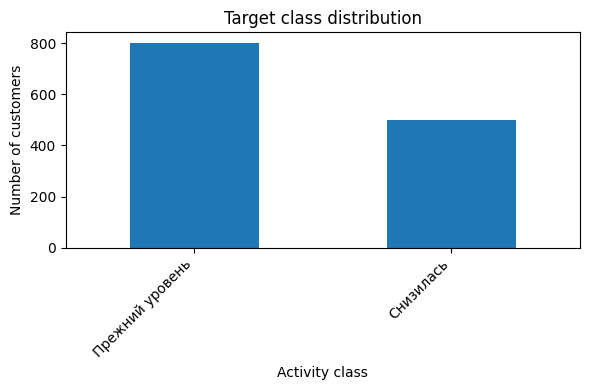


==== тип_сервиса ==== 

count         1300
unique           2
top       стандарт
freq           924
Name: тип_сервиса, dtype: object 



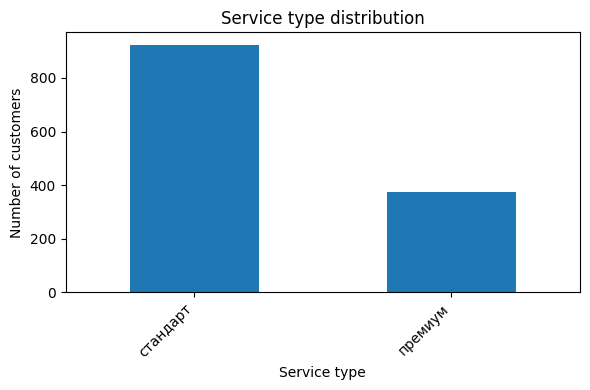


==== разрешить_сообщать ==== 

count     1300
unique       2
top         да
freq       962
Name: разрешить_сообщать, dtype: object 



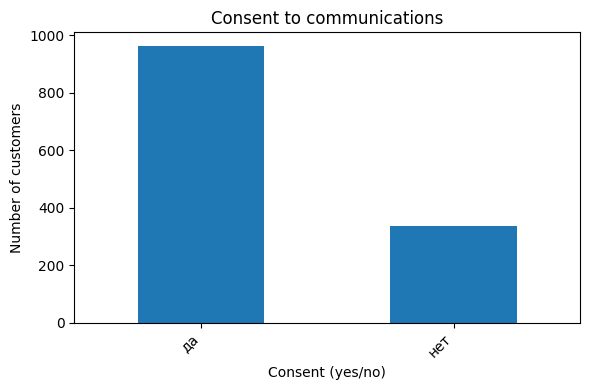


==== маркет_актив_6_мес ==== 

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 



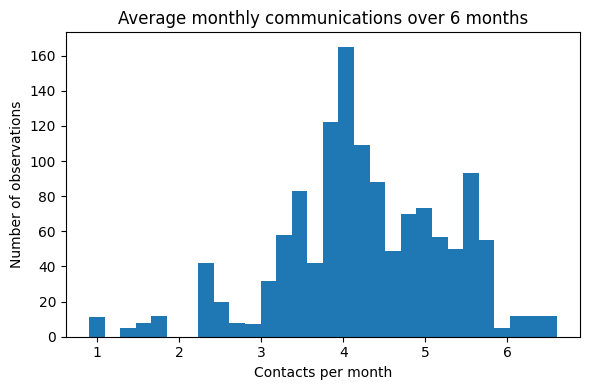

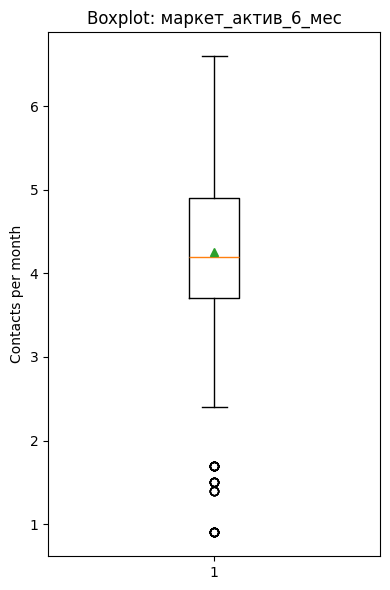


==== маркет_актив_тек_мес ==== 

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64 



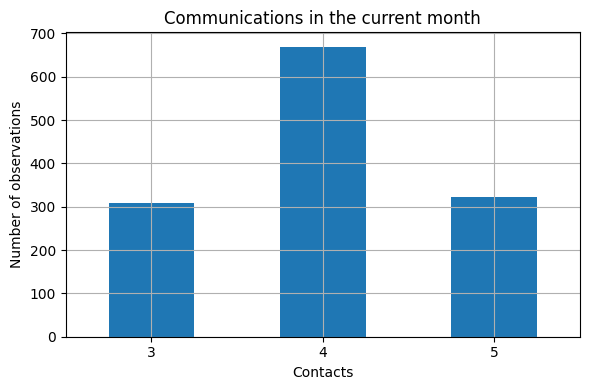


==== длительность ==== 

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 



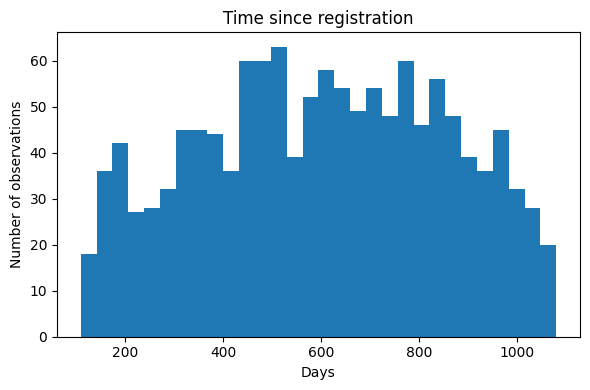

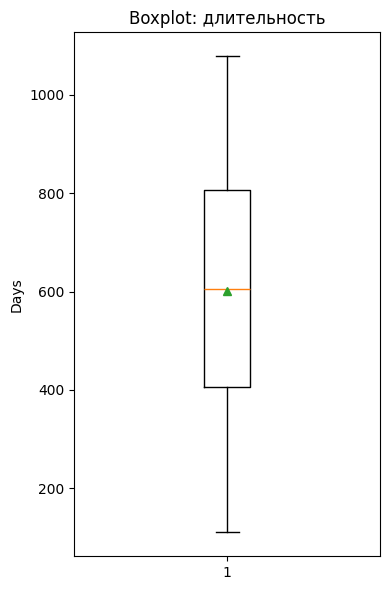


==== акционные_покупки ==== 

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64 



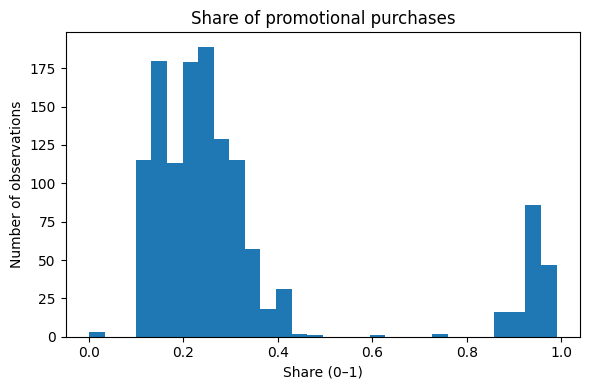

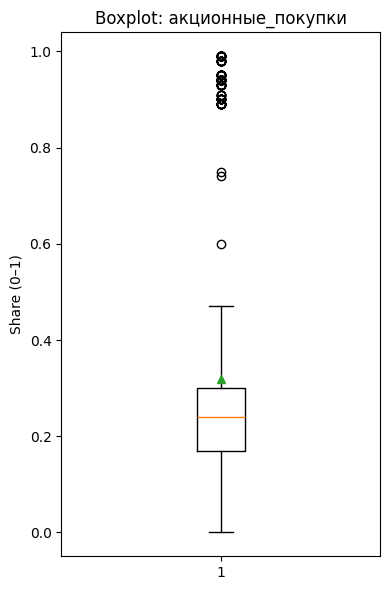


==== популярная_категория ==== 

count                 1300
unique                   6
top       Товары для детей
freq                   330
Name: популярная_категория, dtype: object 



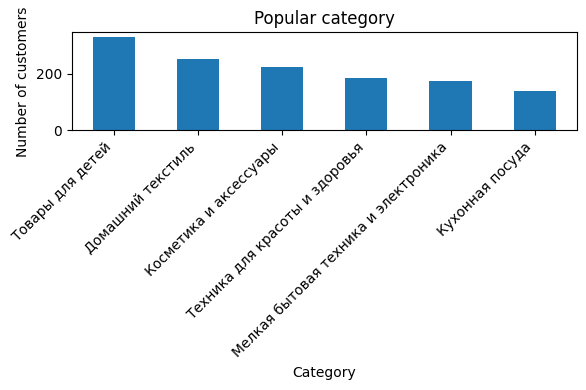


==== средний_просмотр_категорий_за_визит ==== 

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64 



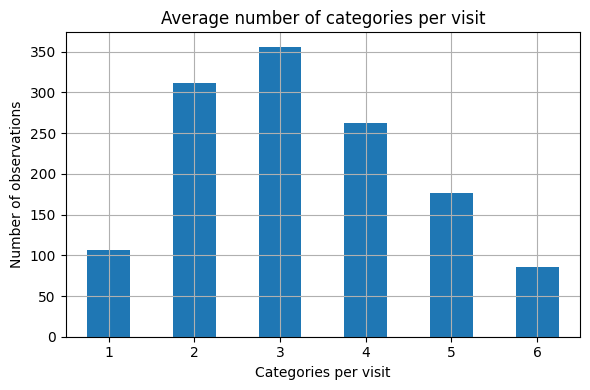


==== неоплаченные_продукты_штук_квартал ==== 

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64 



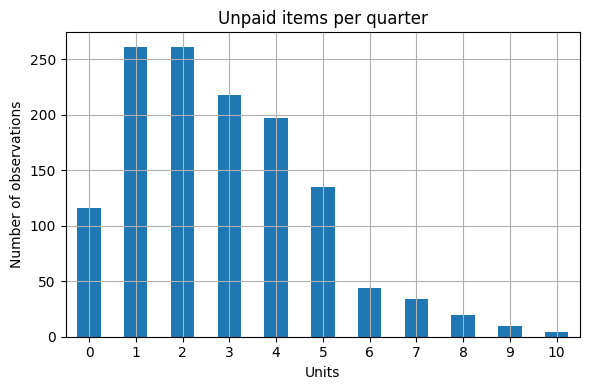


==== ошибка_сервиса ==== 

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64 



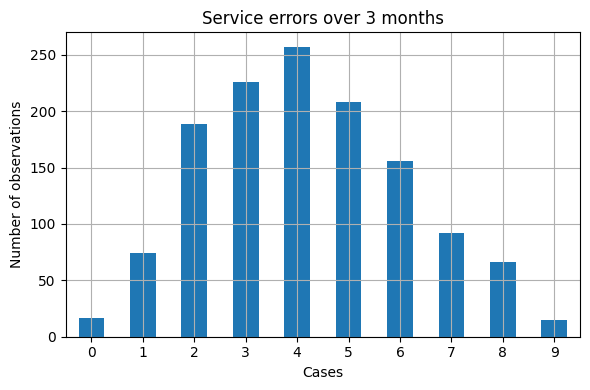


==== страниц_за_визит ==== 

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64 



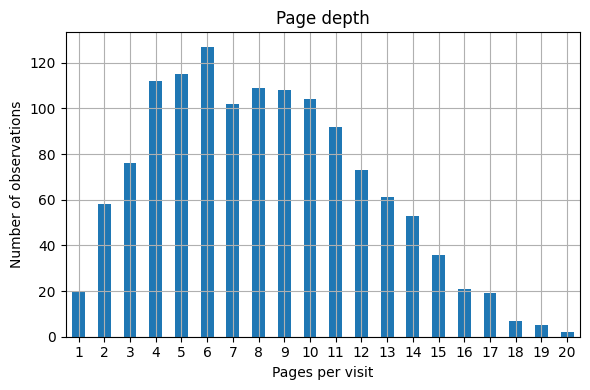

In [18]:
learn_data(market_file)


==== период ==== 

count                    3900
unique                      3
top       препредыдущий_месяц
freq                     1300
Name: период, dtype: object 



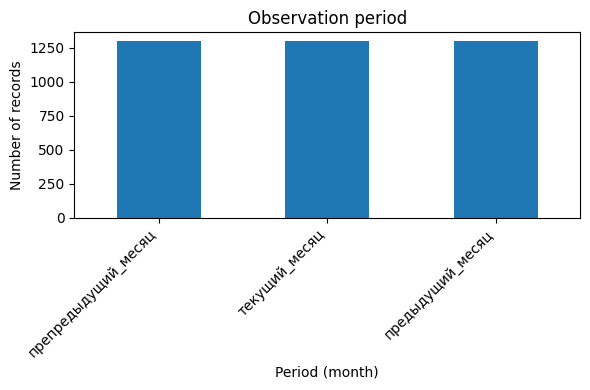


==== выручка ==== 

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64 



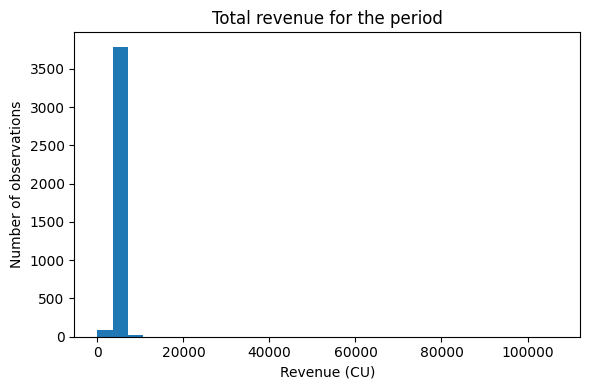

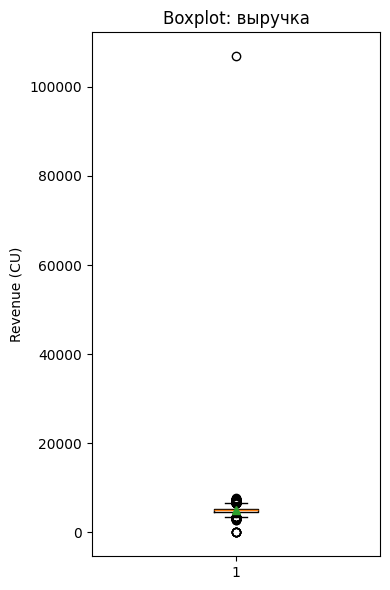

In [19]:
learn_data(market_money)


==== период ==== 

count              2600
unique                2
top       текущий_месяц
freq               1300
Name: период, dtype: object 



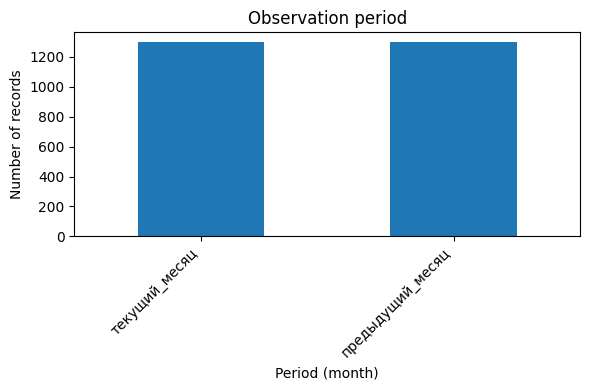


==== минут ==== 

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64 



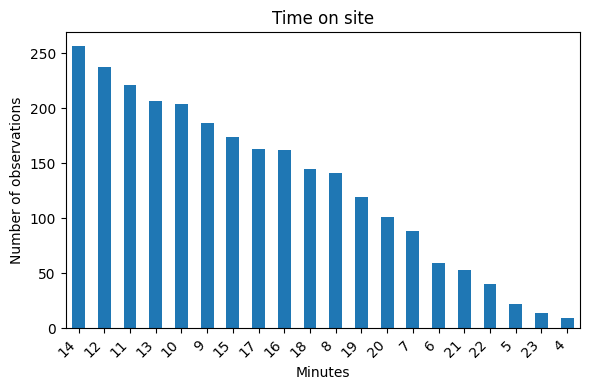

In [20]:
learn_data(market_time)


==== прибыль ==== 

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64 



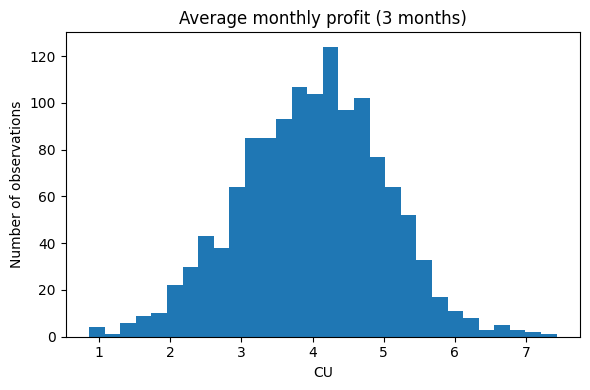

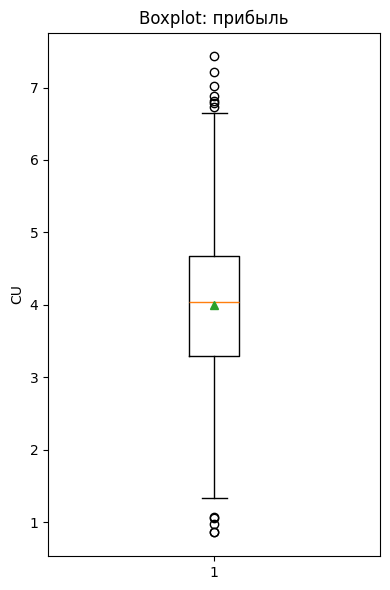

In [21]:
learn_data(money)

### Exploratory Data Analysis — Conclusions

**1) Target feature**

* **Target**: `покупательская_активность` — classes *“Same level”* and *“Decreased”*.
* **Distribution**: *Same level* — **61.69%** (802 customers), *Decreased* — **38.31%** (498 customers).
  **Conclusion:** moderate class imbalance (~62/38). Stratified splitting is recommended for modeling.

**2) Categorical features**

* **Service type**: *standard* — **924**, *premium* — **376**.
* **Allow communications**: *yes* — **962**, *no* — **338**.
* **Popular category (top-3)**:

  1. *Children’s products*
  2. *Home textiles*
  3. *Cosmetics and accessories*

**3) Numerical features (market_file)**

Key statistics (**min / median / mean / max**):

* **маркет_актив_6_мес**: 0.9 / **4.20** / 4.25 / 6.6
* **маркет_актив_тек_мес**: 3.0 / **4.00** / 4.01 / 5.0
* **длительность** (days since registration): 110 / **606** / 601.9 / 1079
* **акционные_покупки** (share): 0.00 / **0.24** / 0.32 / 0.99
* **средний_просмотр_категорий_за_визит**: 1 / **3** / 3.27 / 6
* **неоплаченные_продукты_штук_квартал**: 0 / **3** / 2.84 / 10
* **ошибка_сервиса**: 0 / **4** / 4.19 / 9
* **страниц_за_визит**: 1 / **8** / 8.18 / 20

**Distribution insights:**

* Marketing activity is **stable on average**: ~4 communications in the current month; ~4.25 as the 6-month average.
* **Promotional purchases** vary widely (up to 0.99), with a median of 0.24.
* **On-site activity**: median of 8 pages per visit and 3 categories; users range from very low to very high activity.

**4) Monetary metrics (market_money) by period**

* min 0 / **median 4,957.5** / mean 5,025.7 / max 106,862.2
  **Dynamics:** a **strong right tail** (rare but very large purchases).

**5) Time on site (market_time) by period**

* min 4 / **median 13.0** / mean 13.34 / max 23

**6) Average monthly seller profit (money)**

* **Profit**: min 0.86 / **median 4.05** / mean 4 / max 7.43 (CU).
  The distribution is compact, with no negative values.


**Anomalies**

* Revenue has a strong right tail (max ≈ 106k).
* The remaining features have reasonable ranges; no anomalies with negative values are observed.


**Filtering rows with abnormally high revenue**


In [22]:
upper_bound = market_money['выручка'].median() * 2

anomalies = market_money[market_money['выручка'] > upper_bound]

print(f'Number of anomalies: {anomalies.shape[0]}')
display(anomalies.sort_values(by='выручка', ascending=False))


Number of anomalies: 1


,id,период,выручка
98,215380,текущий_месяц,106862.2


In [23]:
market_money[market_money['id']==215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


For the customer with **id = 215380**, in the two previous months the revenue values were:

* **5,051** and **6,077** (normal values),

* followed by a sudden spike to **106,862**, which is about **20 times higher** than the usual level.

This indicates a clear outlier (anomalous transaction) rather than a typical change in customer behavior.

Since there are no signs of a systemic error, this can be considered a one-off spike or a data entry error. Therefore, it is reasonable to replace the revenue for the current month with a value inferred from the customer’s “normal” behavior—for example, the **mean** or **median** of the previous months.

**Mean of the previous periods**


In [24]:
prev_values_mean = market_money.query("id == 215380 and период != 'текущий_месяц'")['выручка'].mean()
prev_values_mean

np.float64(5564.0)

**It is also possible to consider the mean or median of “similar” customers**


In [25]:
market_file[market_file['id']==215380]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


**Let’s take the median of customers of the same type: consider buyers with the *Premium* service type.**

In [26]:
median_similar = (
    market_money.merge(market_file[['id','тип_сервиса', 'популярная_категория']], on='id')
    .query("тип_сервиса == 'премиум' and период == 'текущий_месяц' and id != 215380")
    ['выручка']
    .median()
)
median_similar

5197.3

**Overall, 5,564.0 and 5,197.3 are close in value.
I decided to take the customer’s average revenue over the previous months (5,564).**

**Let’s replace the current month’s revenue:**

In [27]:
market_money.loc[(market_money['id'] == 215380) & (market_money['период'] == 'текущий_месяц'), 'выручка'] = prev_values_mean

__Verification__

In [28]:
market_money[market_money['id']==215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,5564.0


### Select customers with purchasing activity for at least three months, i.e., those who made purchases during this period


**Transform `market_money` from long format to wide format (by periods)**


In [29]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [30]:
rev_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
rev_pivot

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [31]:
buyers_3m = rev_pivot.loc[(rev_pivot[['текущий_месяц','предыдущий_месяц','препредыдущий_месяц']] > 0).all(axis=1)].reset_index()
buyers_3m.columns.name = None
buyers_3m = buyers_3m.rename(columns={
    'текущий_месяц': 'текущий_месяц_выручка',
    'предыдущий_месяц': 'предыдущий_месяц_выручка',
    'препредыдущий_месяц': 'препредыдущий_месяц_выручка'
})
buyers_3m

,id,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6



==== предыдущий_месяц_выручка ==== 

count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: предыдущий_месяц_выручка, dtype: float64 



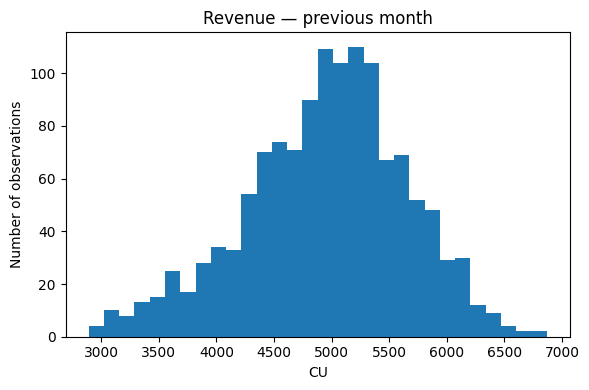

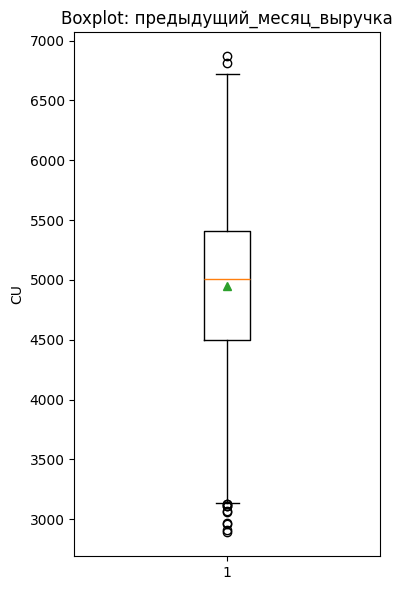


==== препредыдущий_месяц_выручка ==== 

count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: препредыдущий_месяц_выручка, dtype: float64 



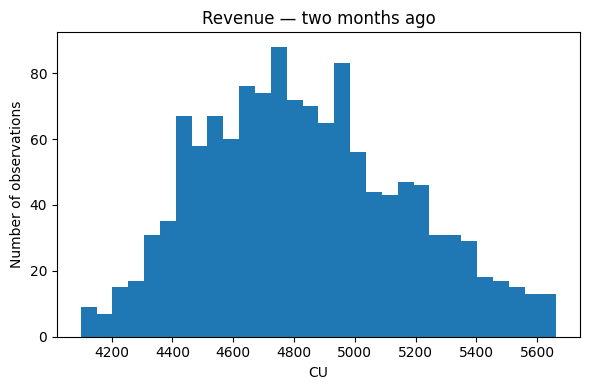

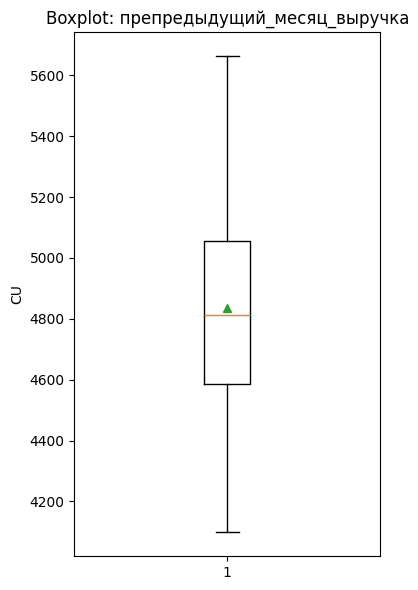


==== текущий_месяц_выручка ==== 

count    1297.000000
mean     5238.347340
std       834.045867
min      2758.700000
25%      4706.600000
50%      5180.300000
75%      5758.600000
max      7799.400000
Name: текущий_месяц_выручка, dtype: float64 



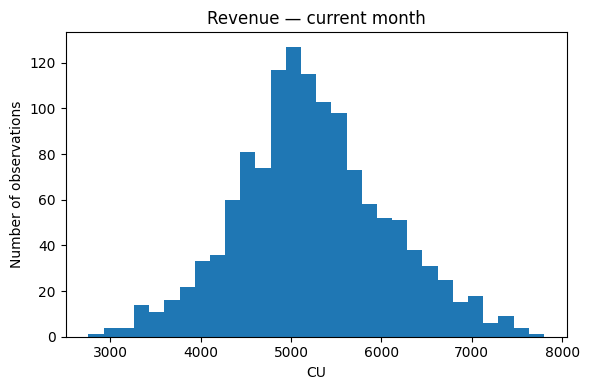

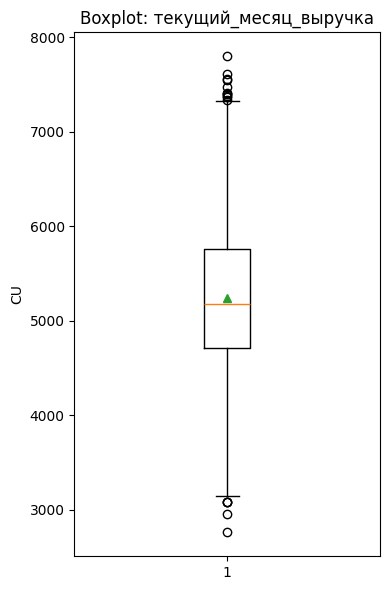

In [32]:
learn_data(buyers_3m)

In [33]:
filtered_market = market_file[market_file['id'].isin(buyers_3m['id'])]
filtered_market_time = market_time[market_time['id'].isin(buyers_3m['id'])]
filtered_money = money[money['id'].isin(buyers_3m['id'])]


==== покупательская_активность ==== 

count                1297
unique                  2
top       Прежний уровень
freq                  802
Name: покупательская_активность, dtype: object 



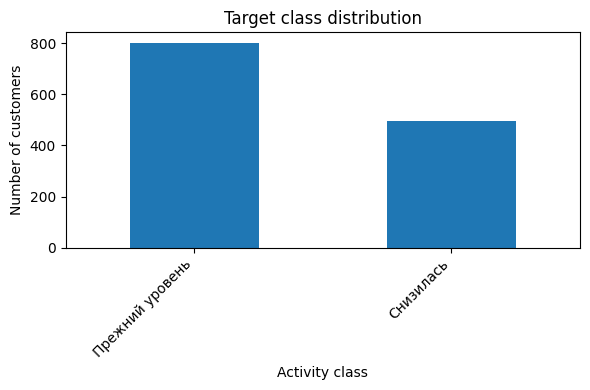


==== тип_сервиса ==== 

count         1297
unique           2
top       стандарт
freq           922
Name: тип_сервиса, dtype: object 



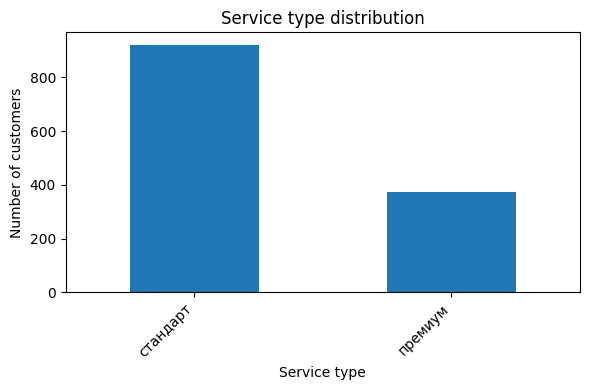


==== разрешить_сообщать ==== 

count     1297
unique       2
top         да
freq       959
Name: разрешить_сообщать, dtype: object 



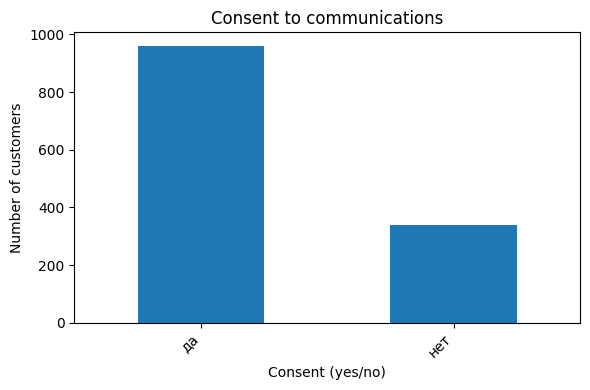


==== маркет_актив_6_мес ==== 

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 



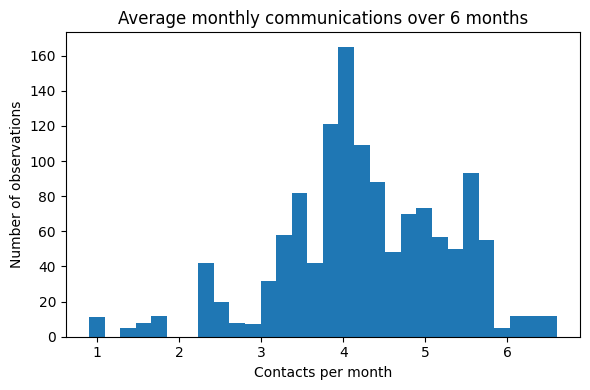

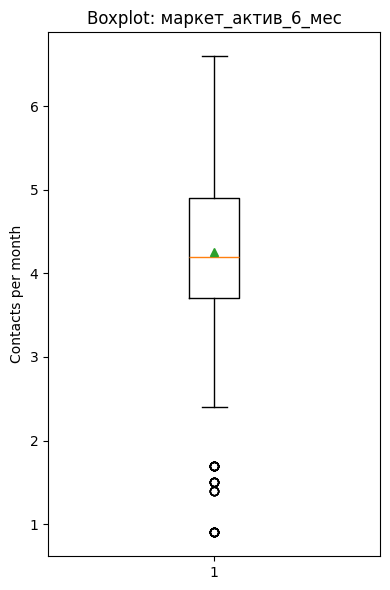


==== маркет_актив_тек_мес ==== 

count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64 



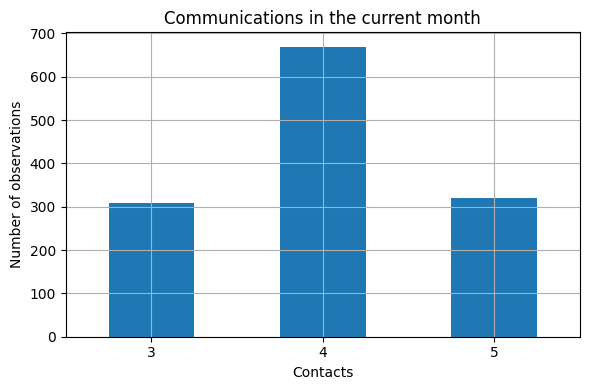


==== длительность ==== 

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 



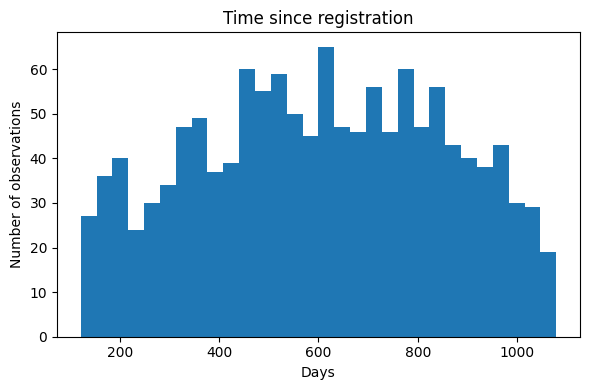

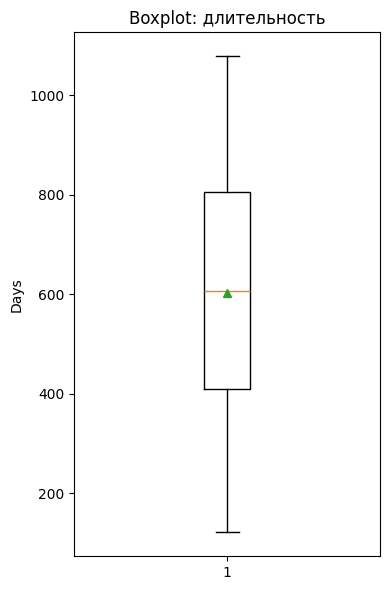


==== акционные_покупки ==== 

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64 



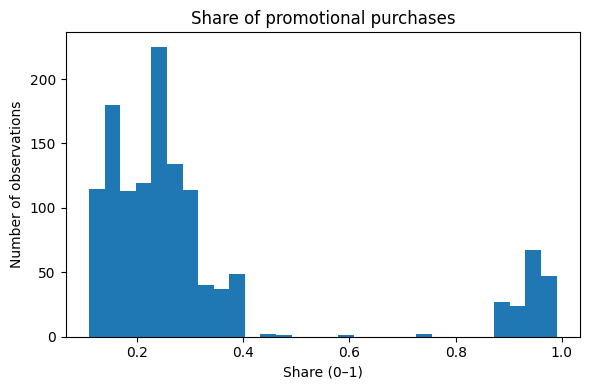

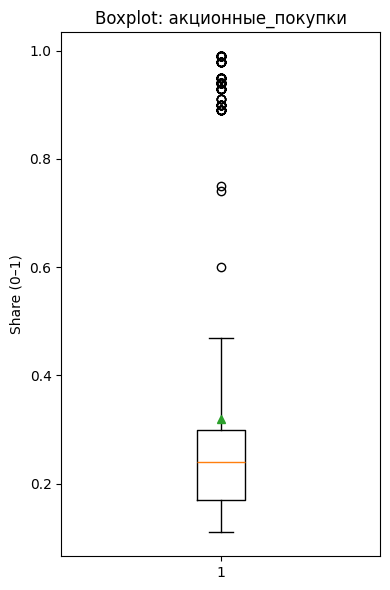


==== популярная_категория ==== 

count                 1297
unique                   6
top       Товары для детей
freq                   329
Name: популярная_категория, dtype: object 



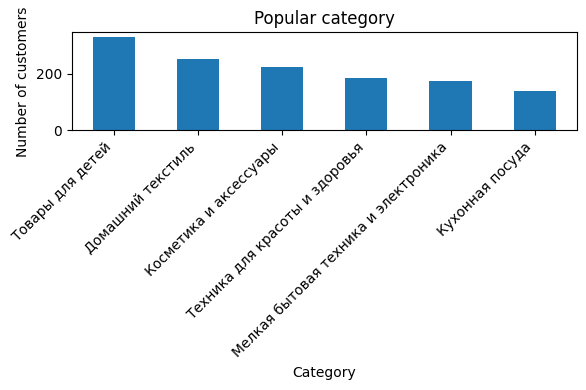


==== средний_просмотр_категорий_за_визит ==== 

count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64 



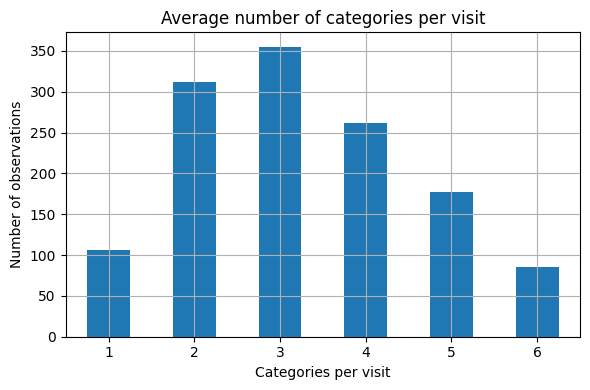


==== неоплаченные_продукты_штук_квартал ==== 

count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64 



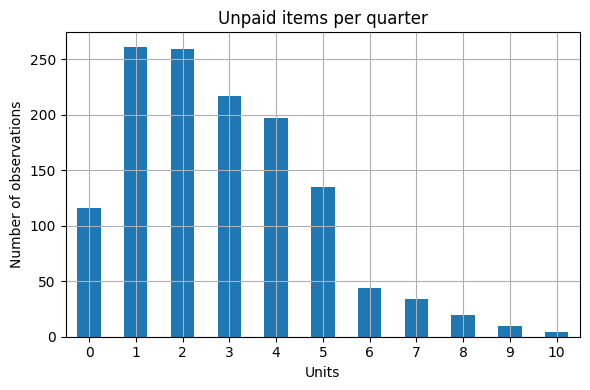


==== ошибка_сервиса ==== 

count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64 



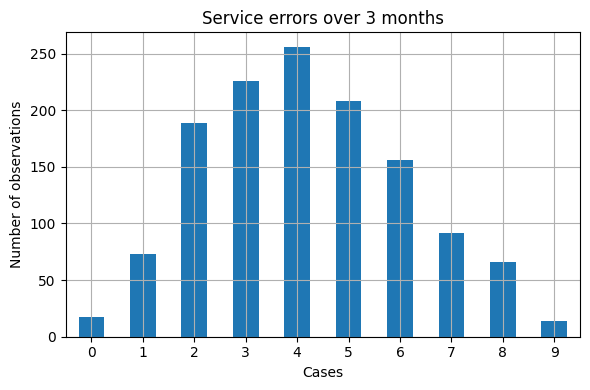


==== страниц_за_визит ==== 

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64 



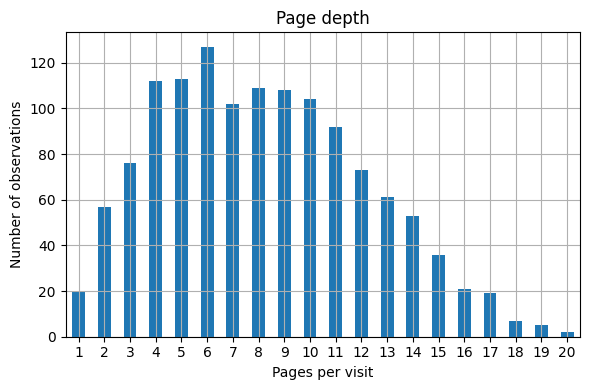

In [34]:
learn_data(filtered_market)


==== период ==== 

count              2594
unique                2
top       текущий_месяц
freq               1297
Name: период, dtype: object 



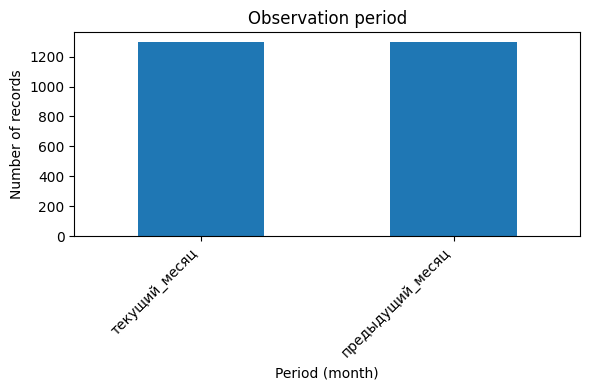


==== минут ==== 

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64 



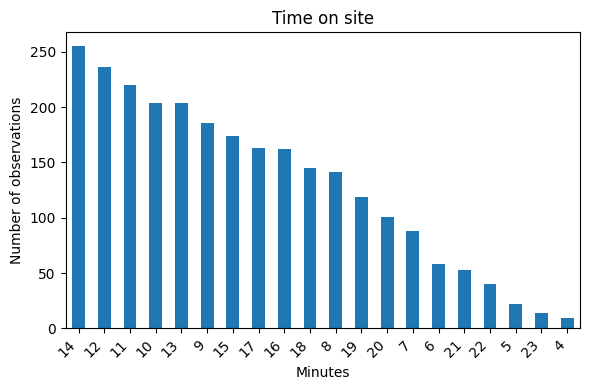

In [35]:
learn_data(filtered_market_time)


==== прибыль ==== 

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64 



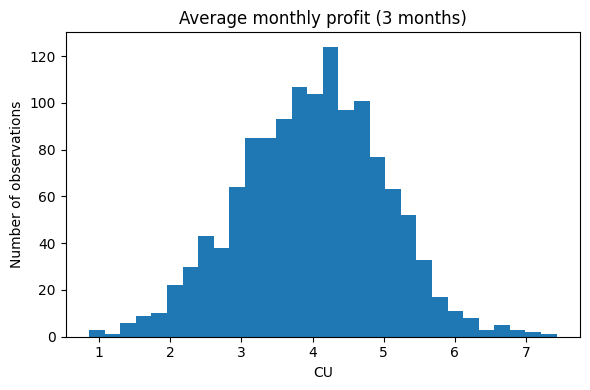

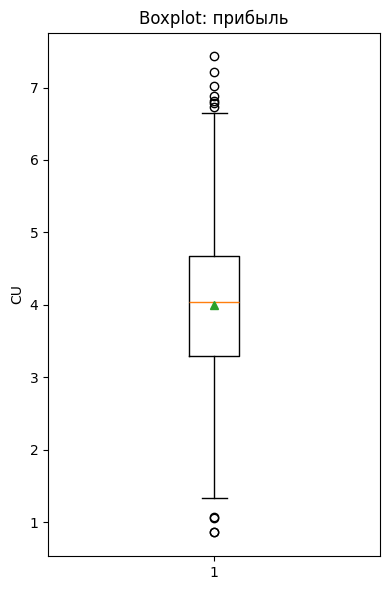

In [36]:
learn_data(filtered_money)

#### Conclusions on selecting customers with purchasing activity

**Figures**

* Total customers in the database: **1,300**
* Selected (purchases in 3 out of 3 months): **1,297** → **99.77%** of the base
* Target distribution among selected customers:

  * **“Same level”** — **802** (**61.84%**)
  * **“Decreased”** — **495** (**38.16%**)

**Conclusions**

* The segment of **customers with purchasing activity** represents the **core** of the customer base (≈99.8%): the vast majority made purchases in **each** of the three months.
* Even within this **core**, the share of **“Decreased”** remains **high (~38%)** — regular purchases do not guarantee sustained activity.


## Merging Tables <a id="merging_tables"></a>

### Merge all tables except `filtered_money`


The tables are merged by `id`, forming a single DataFrame that includes:

* Behavioral and marketing features (`market_file`)

* Revenue for three periods (`текущий_месяц_выручка`, `предыдущий_месяц_выручка`, `препредыдущий_месяц_выручка`)

* Time spent on the site by period (`текущий_месяц_минут`, `предыдущий_месяц_минут`)


Transform `filtered_market_time` from long format to wide format (by periods).


In [37]:
filtered_market_time.head()

,id,период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


In [38]:
time_pivot = filtered_market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum').reset_index()
time_pivot.columns.name = None
time_pivot = time_pivot.rename(columns={
    'текущий_месяц': 'текущий_месяц_минут',
    'предыдущий_месяц': 'предыдущий_месяц_минут'})
time_pivot

,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


**Merge everything except `filtered_money`**


In [39]:
merged = (filtered_market
          .merge(buyers_3m, on='id', how='left')
          .merge(time_pivot, on='id', how='left'))
merged

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


## Correlation Analysis <a id="correlation_analysis"></a>


### Correlation matrix (Pearson and Spearman)


**Checking normality for continuous features**


In [40]:
normal_like = []
non_normal  = []

for col in continuous:
    if col not in merged.columns:
        continue
        
    s = merged[col].dropna()
    stat, p = normaltest(s)
    if p > 0.05:
        normal_like.append(col)
    else:
        non_normal.append(col)

print("≈Normal:", normal_like)
print("Non-normal:", non_normal)


≈Normal: []
Non-normal: ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'текущий_месяц_выручка', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка']


**None of the continuous features passed the `normaltest` normality test**

**What to do next:**

* For numerical features, use **Spearman** correlation instead of Pearson. Spearman is suitable for non-normally distributed numerical relationships and for discrete numerical variables.
* For mixed / categorical relationships, use **Phik**.
* **Why not Pearson for continuous features:** the normality assumptions are violated; Pearson can distort the relationship estimates (it is sensitive to nonlinearity and skewness).


**For numerical features, we use Spearman correlation instead of Pearson:**

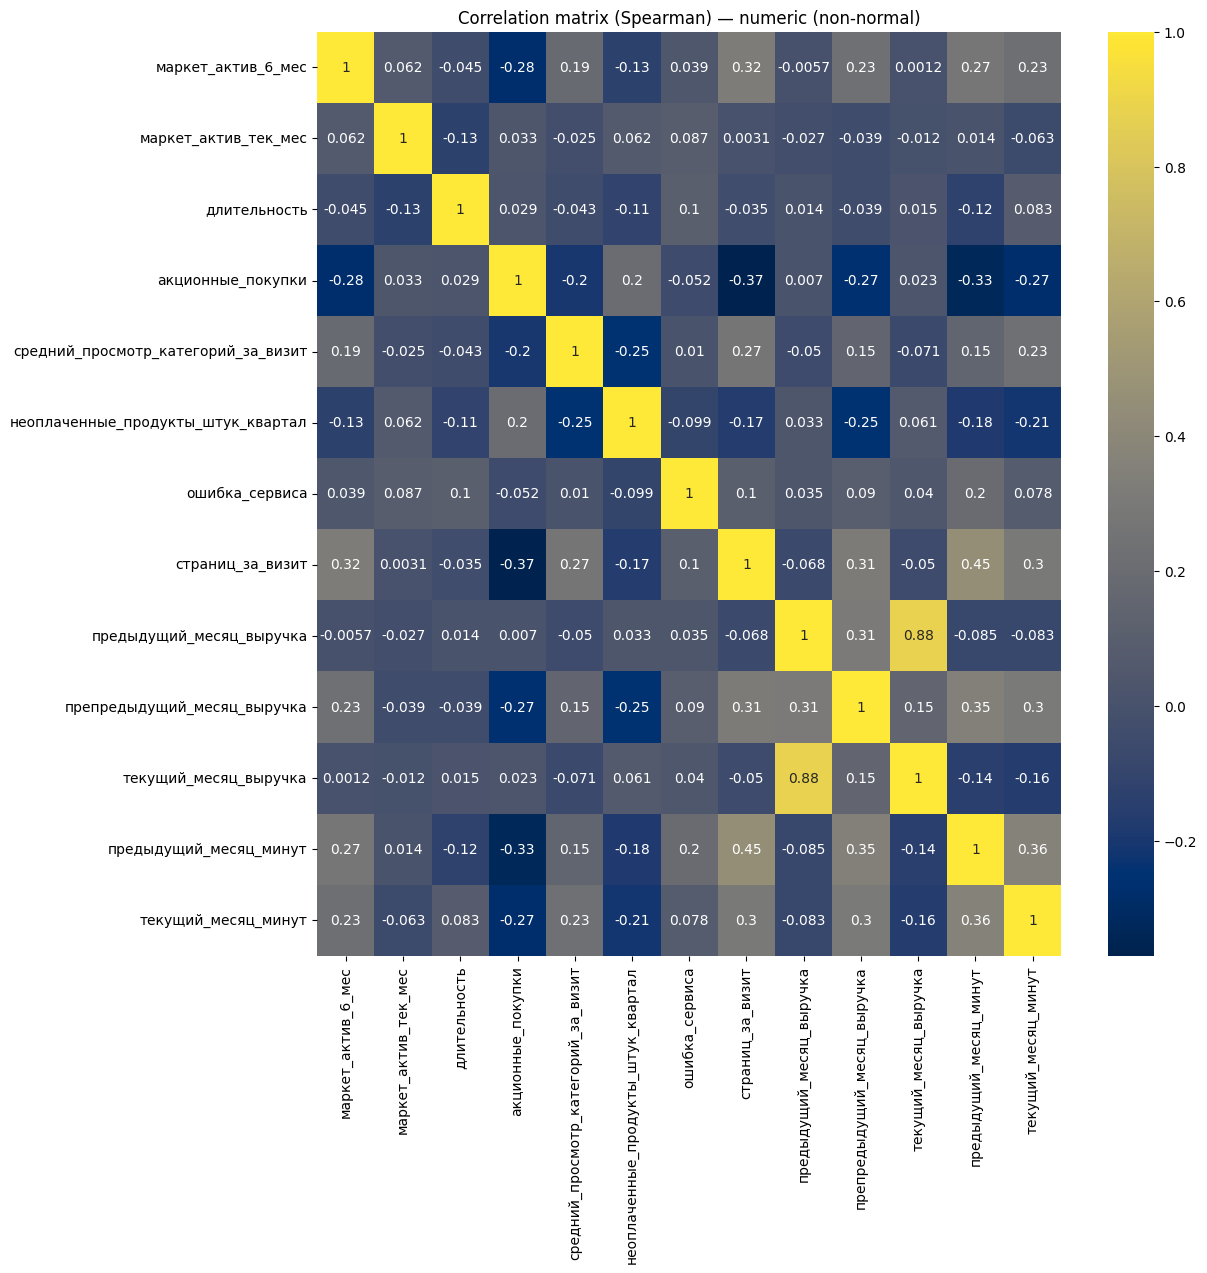

In [41]:
num_cols = merged.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c != 'id']

plt.figure(figsize=(12, 12))
sns.heatmap(merged[num_cols].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

### Correlation matrix (Phik: numerical + categorical)

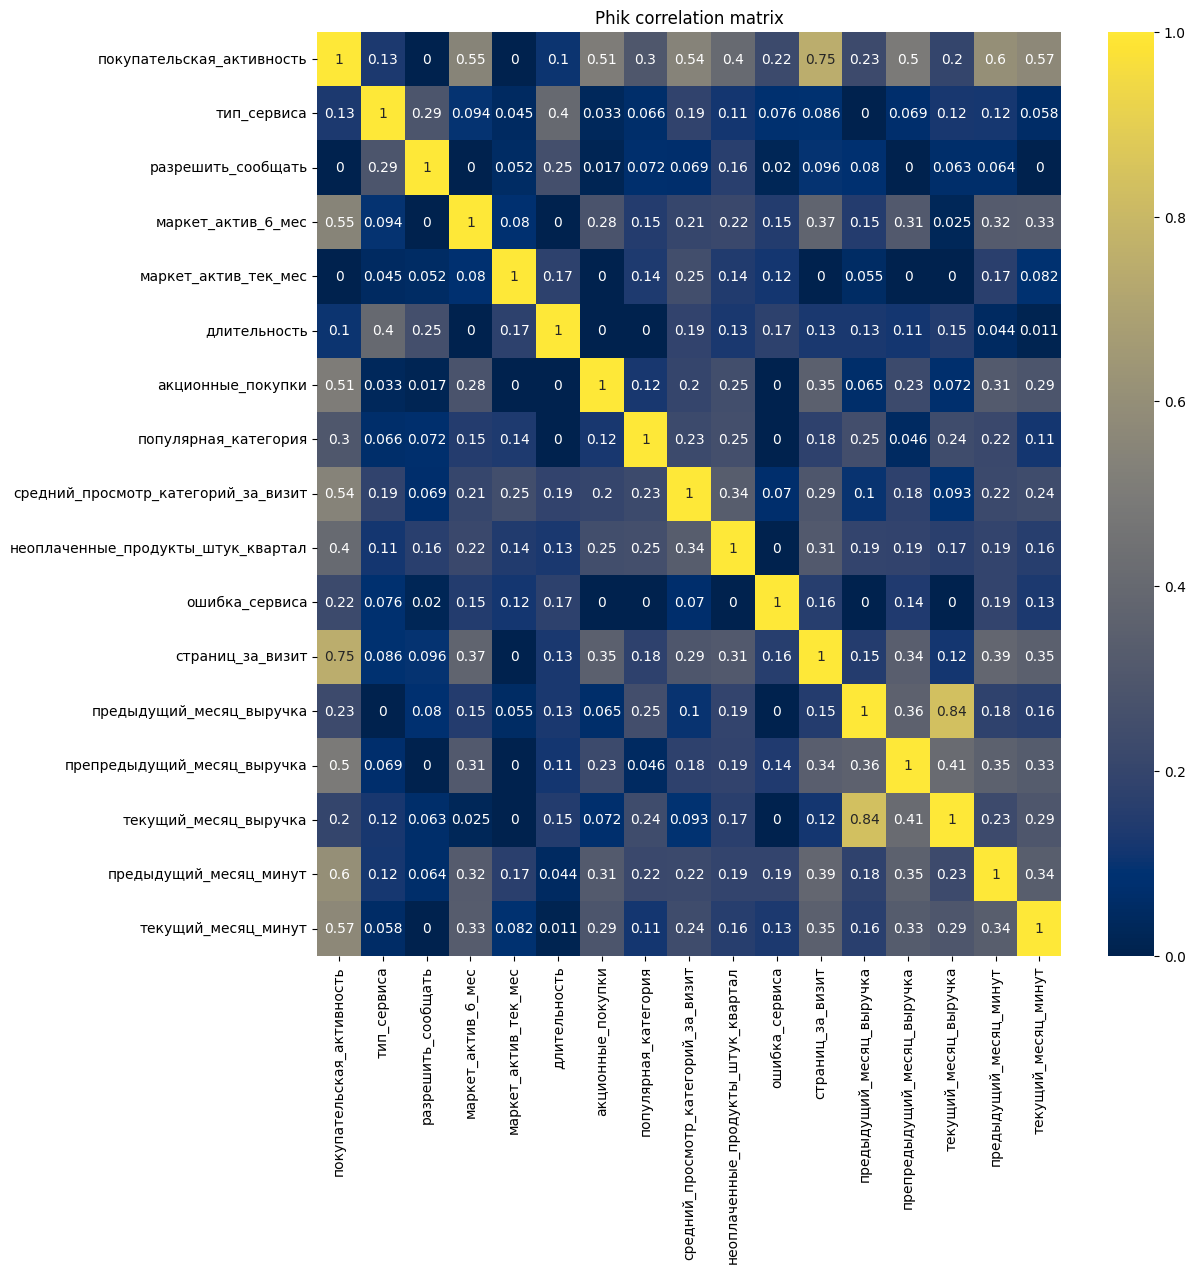

In [42]:
interval_cols = [c for c in continuous if c in merged.columns]

phik_corr = merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [43]:
phik_corr

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
покупательская_активность,1.000000,0.132247,0.000000,0.546370,0.000000,0.101767,0.506991,0.298036,0.539221,0.404382,0.223697,0.746825,0.227280,0.495174,0.196561,0.603903,0.569310
тип_сервиса,0.132247,1.000000,0.286278,0.094182,0.044796,0.401158,0.033339,0.066285,0.186635,0.113537,0.076182,0.085602,0.000000,0.068507,0.121554,0.119901,0.058241
разрешить_сообщать,0.000000,0.286278,1.000000,0.000000,0.051971,0.253956,0.017252,0.071769,0.069322,0.162090,0.020464,0.096356,0.079830,0.000000,0.062568,0.064223,0.000000
маркет_актив_6_мес,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.215195,0.147270,0.373372,0.149129,0.312243,0.024850,0.322162,0.329320
маркет_актив_тек_мес,0.000000,0.044796,0.051971,0.080454,1.000000,0.174385,0.000000,0.136175,0.246726,0.142490,0.116310,0.000000,0.054683,0.000000,0.000000,0.165172,0.082378
длительность,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.127667,0.174467,0.128218,0.125303,0.114058,0.147306,0.044233,0.010546
акционные_покупки,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.246303,0.000000,0.350551,0.065412,0.225681,0.072241,0.313361,0.287061
популярная_категория,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.254675,0.000000,0.177702,0.250974,0.045814,0.236739,0.218230,0.113751
средний_просмотр_категорий_за_визит,0.539221,0.186635,0.069322,0.205783,0.246726,0.187774,0.199417,0.225622,1.000000,0.335031,0.069908,0.294140,0.100332,0.176770,0.092944,0.218956,0.236461
неоплаченные_продукты_штук_квартал,0.404382,0.113537,0.162090,0.215195,0.142490,0.127667,0.246303,0.254675,0.335031,1.000000,0.000000,0.310950,0.193752,0.189721,0.165773,0.193912,0.157826


### Conclusions from the correlation analysis

### Conclusions from the correlation analysis (Spearman and Phik)

**Numerical features (Spearman)**

**Strong and moderate relationships between monthly metrics**

* **текущий_месяц_выручка ↔ предыдущий_месяц_выручка = 0.88** — the strongest pair: customer revenue is highly correlated across adjacent months (inertia of purchasing behavior).
  This indicates **multicollinearity within the monetary block** (stability of customer spending).

**Weak relationships “revenue ↔ time”**

* Pairs of “revenue ↔ minutes” show **weak correlations**, indicating the absence of a direct linear relationship between “time spent” and “money spent” at the customer/month level.

---

**Mixed features (Phik: numerical + categorical)**

* **страниц_за_визит ↔ покупательская_активность = 0.75** — strong association with the target.
* **предыдущий_месяц_минут ↔ покупательская_активность = 0.69** — moderate-to-strong association.
* **средний_просмотр_категорий_за_визит ↔ покупательская_активность = 0.54** — moderate association.
* **маркет_актив_6_мес ↔ покупательская_активность = 0.55** — moderate association.
* **неоплаченные_продукты_штук_квартал ↔ покупательская_активность = 0.50** — moderate association.
* **акционные_покупки ↔ покупательская_активность = 0.51** — moderate association.
* **текущий_месяц_минут ↔ покупательская_активность = 0.58** — moderate association.
* **покупательская_активность ↔ тип_сервиса ≈ 0.13** — weak association (the difference between “standard” and “premium” has little impact on the probability of activity decline).

---

**What this means for the model**

* **Key retention drivers**: on-site behavior (страниц_за_визит, средний_просмотр_категорий_за_визит, предыдущий_месяц_минут, текущий_месяц_минут) and long-term marketing activity (маркет_актив_6_мес).

* **Risk signals**: акционные_покупки and неоплаченные_продукты_штук_квартал — early indicators of potential decline.

* **Monetary features** are less directly related to the target on their own; their **dynamics** (deltas/trends) are more informative, given the high stability across months.

* **Multicollinearity**: monthly revenue features (текущий_месяц_выручка ↔ предыдущий_месяц_выручка).
  For linear models — use regularization/feature selection; for nonlinear models — this is generally acceptable.


## Using Pipelines <a id="using_pipelines"></a>

In [44]:
merged.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Tuning strategy**

I use a single `ColumnTransformer` (two encodings: `OneHotEncoder` for nominal features, `OrdinalEncoder` for ordered categories; for numerical features — either `StandardScaler` / `MinMaxScaler` / `passthrough`, depending on the experiment).

The model is selected via `RandomizedSearchCV(cv=5, scoring='roc_auc')` — randomized cross-validation and a threshold-independent metric to rank the risk of the *“Decreased”* class.

The hyperparameter space is focused on controlling complexity (Decision Tree), smoothness of the decision boundary (KNN), sparsity and interpretability (Logistic Regression with L1), and nonlinearity (SVC with kernel choice).


**Metric justification**

ROC-AUC is chosen because the task is to rank customers by the risk of *“Decreased”* activity under a moderate class imbalance. ROC-AUC is threshold-independent, more robust to class imbalance, and comparable across models. All four models support ROC-AUC evaluation.


In [45]:
# prepare the data
X_train, X_test, y_train, y_test = train_test_split(
    merged.drop(['id','покупательская_активность'], axis=1),
    merged['покупательская_активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=merged['покупательская_активность']
)

label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.transform(y_test)

print("Sample sizes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# create lists with feature names
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = merged.drop(['id'], axis=1).select_dtypes(include='number').columns.tolist()

# pipeline for features from ohe_columns: imputation + OHE
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

# pipeline for features from ord_columns: imputation + Ordinal encoding
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[['стандарт', 'премиум']],
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# common preprocessing pipeline
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# final pipeline: preprocessing + model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions = [
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # SVC
    {
        'models': [SVC()],
        'models__kernel': ['poly', 'sigmoid', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=30,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train_label)

print('Best model and its parameters:\n\n', randomized_search.best_estimator_)
print('Best model ROC-AUC on the training set:', randomized_search.best_score_)


Sample sizes:
X_train: (972, 16)
X_test: (325, 16)
y_train: (972,)
y_test: (325,)
Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeli

In [46]:
pd.DataFrame(y_train_label, y_train, columns=['LabelEncoder']) 

,LabelEncoder
покупательская_активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0
Снизилась,1
...,...
Прежний уровень,0
Прежний уровень,0
Снизилась,1


### **Best model — LogisticRegression (L1, C=3, solver=liblinear)**

* **Why LogisticRegression (L1):** an interpretable model; L1 regularization performs implicit feature selection and reduces overfitting.
* **Why C = 3:** selected via cross-validation as a balance between strong regularization and model performance.
* **Why ROC-AUC:** the task requires ranking customers by risk; the metric is robust to class imbalance and threshold-independent.

**Average ROC-AUC of the best configuration ≈ 0.898**

In [47]:
# Predictions on the test set
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]

# ROC-AUC evaluation on the test set
test_auc = roc_auc_score(y_test_label, y_pred_proba)
print(f'ROC-AUC on the test set: {test_auc:.3f}')

ROC-AUC on the test set: 0.923


### **Interpretation of the result**

* **ROC-AUC = 0.923** on the test set — this is a very high quality metric.
* A value of **0.923** means that in **92.3%** of cases the model correctly distinguishes positive and negative examples, indicating strong predictive power.
* Using a pipeline with data preprocessing and hyperparameter tuning via `RandomizedSearchCV` produced a stable and reliable result.
* The model generalizes well and is not overfitted, as the test performance remains high after cross-validation.


In [48]:
# Baseline model
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train_label)

# Evaluate DummyClassifier performance
dummy_pred = dummy.predict_proba(X_test)[:, 1]
dummy_auc = roc_auc_score(y_test_label, dummy_pred)

print(f'ROC-AUC DummyClassifier: {dummy_auc:.3f}')

# Comparison with the best model
best_auc = roc_auc_score(
    y_test_label,
    randomized_search.predict_proba(X_test)[:, 1]
)
print(f'ROC-AUC of the best model: {best_auc:.3f}')
print(f'Improvement over baseline: {best_auc - dummy_auc:.3f}')


ROC-AUC DummyClassifier: 0.500
ROC-AUC of the best model: 0.923
Improvement over baseline: 0.423


**Interpretation**

If the ROC-AUC of the best model is significantly higher than that of the Dummy classifier (for example, **0.92 vs. 0.50**), this confirms that the model is genuinely learning meaningful patterns from the data and producing informative predictions, rather than reproducing random or trivial behavior.


## Feature Importance Analysis <a id="feature_importance_analysis"></a>

In [49]:
best_pipe = randomized_search.best_estimator_
model = best_pipe.named_steps['models']

# Extract coefficients of the logistic regression model
coefficients = model.coef_[0]

# Get feature names after preprocessing
feat_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

# (optional) clean up prefixes
feat_names = [
    f.replace('ohe__', '')
     .replace('ord__', '')
     .replace('num__', '')
    for f in feat_names
]

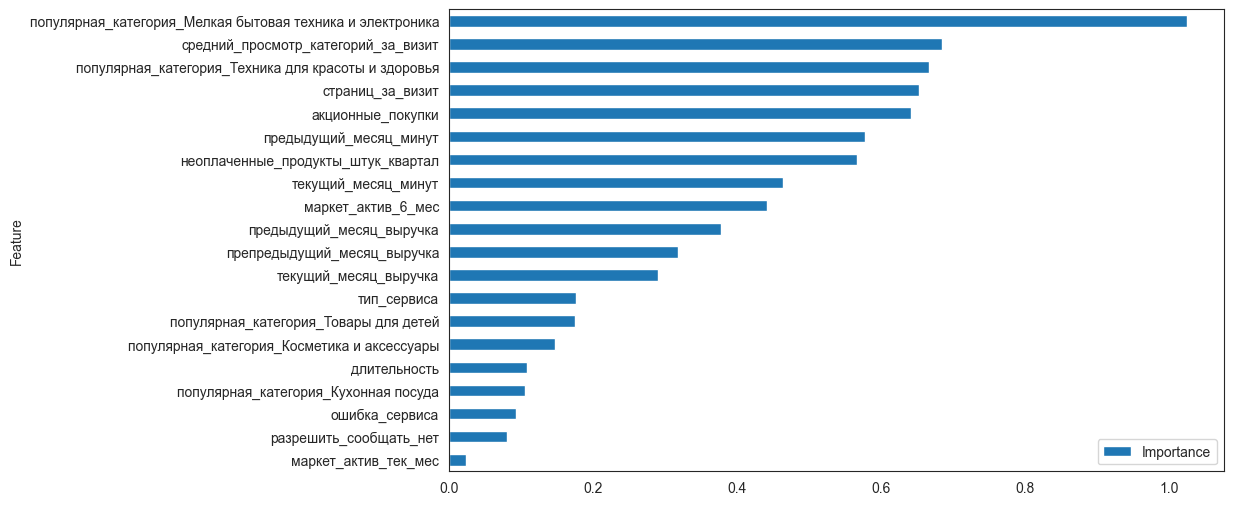

In [50]:
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': feat_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

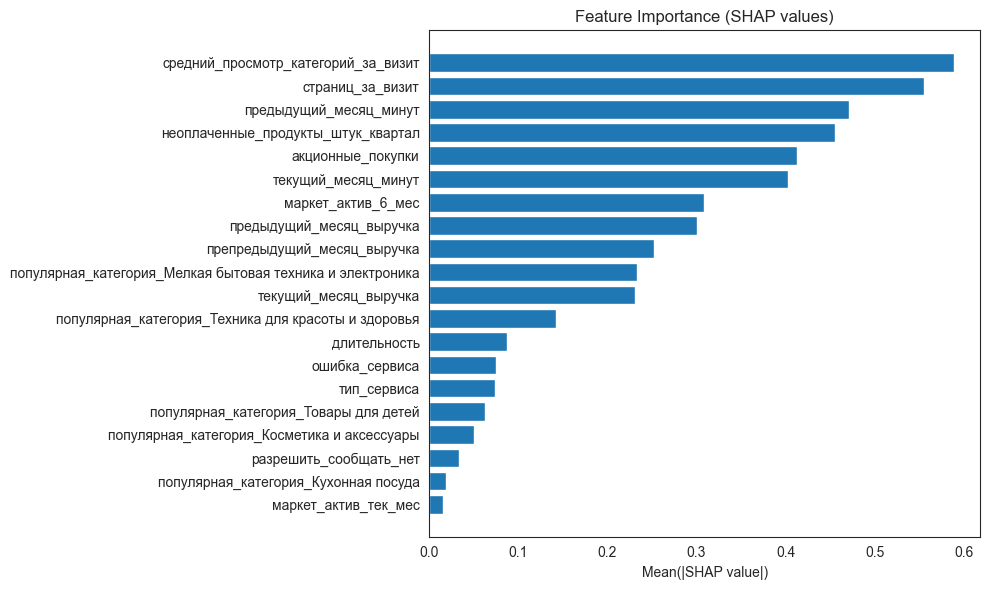

In [51]:
preproc = best_pipe.named_steps['preprocessor']
Xtr = preproc.transform(X_train)
Xte = preproc.transform(X_test)
explainer = shap.LinearExplainer(model, Xtr)
shap_values = explainer(Xte)


shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({'Feature': feat_names, 'Importance': shap_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Mean(|SHAP value|)")
plt.title("Feature Importance (SHAP values)")
plt.tight_layout()
plt.show()

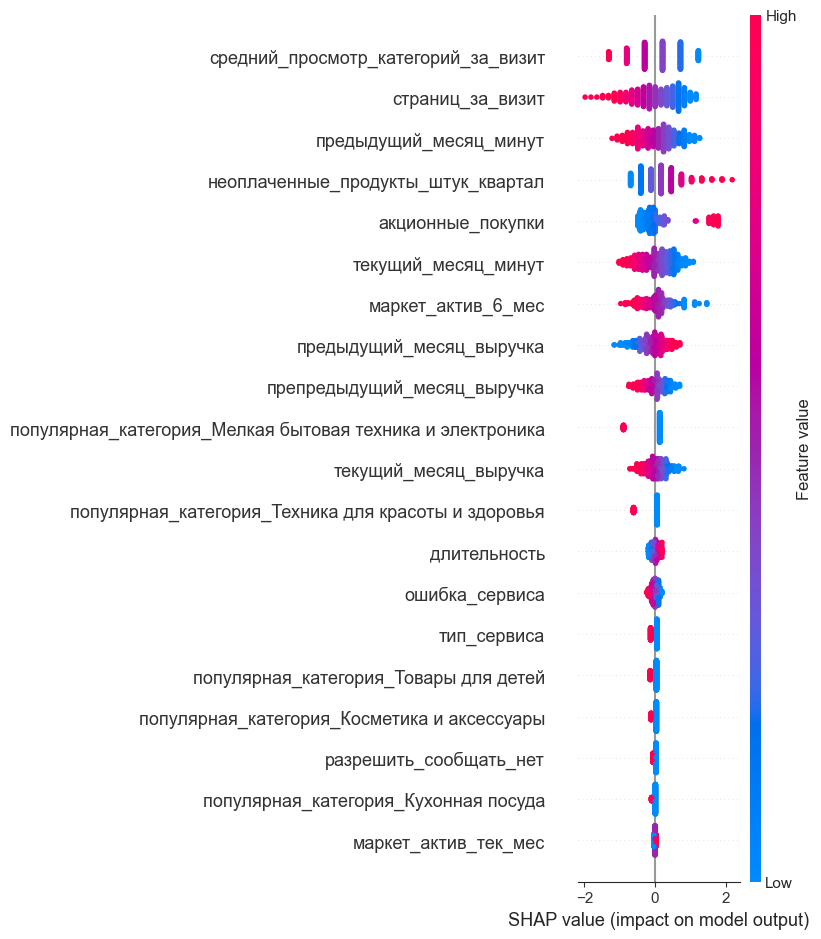

In [52]:
shap.summary_plot(shap_values, Xte, feature_names=feat_names)

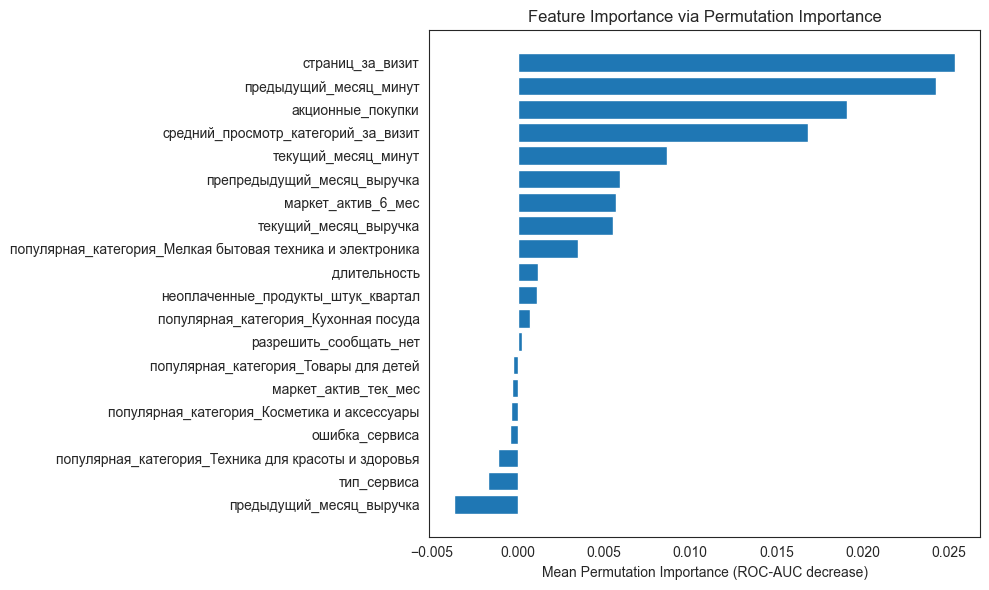

In [53]:
# permutation importance
result = permutation_importance(
    model, Xte, y_test, scoring='roc_auc', n_repeats=10, random_state=42
)


feature_importance = pd.DataFrame({
    'Feature': feat_names,
    'Importance': result.importances_mean
})


feature_importance = feature_importance.sort_values('Importance', ascending=True)


sns.set_style('white')
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Mean Permutation Importance (ROC-AUC decrease)")
plt.title("Feature Importance via Permutation Importance")
plt.tight_layout()
plt.show()


## **Final model**

* The best model from the search is **LogisticRegression (L1, C=3, solver=liblinear)**; it was selected in the notebook by `RandomizedSearchCV` using the **ROC-AUC** metric (k-fold CV).
  The average ROC-AUC of the best configuration is ≈ **0.898**.

**How feature importance was computed**

* **Model coefficients** of the best model (LogisticRegression with L1) — absolute values of coefficients after preprocessing.
* **SHAP** for the linear model — mean absolute SHAP values.
* **Permutation importance** on validation — the drop in ROC-AUC when a feature is permuted.

**What most strongly influences the target**

* **Most important features:**

1. **Behavioral metrics:**

   * `страниц_за_визит` and `средний_просмотр_категорий_за_визит` — higher engagement (more pages and categories viewed) reduces the risk of activity decline.
   * `время_на_сайте` (especially for the previous month) — more time spent → more stable activity.

2. **Marketing history:**

   * `маркет_актив_6_мес` — accumulated communication with the brand protects against churn.
   * `акционные_покупки` — a high share of promotional purchases increases the risk of activity decline (discount dependence).

3. **Highly significant categorical feature:**

   * **`популярная_категория = "Small household appliances and electronics", "Beauty and health equipment"`** — stands out as a **high-impact factor**.
     Customers who frequently purchase from this category show more stable behavior and a lower risk of activity decline.

* **Moderate importance:**

  * `длительность` (tenure since registration) — moderately important.
  * `неоплаченные_продукты_штук_квартал` — moderately important.

* **Low-importance features:**

  * `тип_сервиса`
  * `маркет_актив_тек_мес`

---

**Conclusions and recommendations**

**For modeling:**

* **L1 regularization** helps eliminate noisy features.
* Focus on **behavioral and marketing features**, including interactions with “popular categories” such as *small household appliances*.
* Add dynamic features (month-to-month deltas, visit frequency, growth/decline of activity).

**For business:**

* **Sustain customer interest in small household appliances**: promote offers and recommendations in this category.
* **Increase engagement** (boost page views and navigation depth).
* **Manage discount dependence**: for high `акционные_покупки`, encourage non-discount purchases via bonuses and personalized programs.
* **Monitor “training” signals** (errors, unpaid items) — automate reminders and customer support.


## Customer Segmentation <a id="customer_segmentation"></a>

### Segmentation

**Segment only the test set**

**Approach**

1. For each customer, we take:

   * **Risk** = `p_drop` = the model’s predicted probability from `predict_proba()`.
   * **Profitability** = taken from `money.csv`.

2. We split customers into quadrants (simple and interpretable). Thresholds are based on quantiles:

   * **Risk**: `p_drop ≥ 0.5` → **High Risk (HR)**; `< 0.5` → **Low Risk (LR)**.
     (0.5 is the standard probability threshold in binary classification.)
   * **Profitability**: `profit ≥ Q3` → **High Profit (HP)**; `< Q3` → **Low Profit (LP)**.

3. This yields **4 basic segments**:

   * **HR–HP**: high risk, high profitability — *“golden customers, but at risk of churn”*.
   * **HR–LP**: high risk, low profitability — *“drifting, but low cost”*.
   * **LR–HP**: low risk, high profitability — *“happy loyal customers”*.
   * **LR–LP**: low risk, low profitability — *“sleeping / basic customers”*.


In [54]:
best_model = randomized_search.best_estimator_

df = merged.loc[X_test.index].copy()  
df['p_drop'] = best_model.predict_proba(X_test)[:, 1]

df = df.merge(
    money[['id','прибыль']],
    on='id', how='left'
)

df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,p_drop,прибыль
0,216446,Прежний уровень,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,4712.0,5160.0,5230.7,15,20,0.436991,4.47
1,215469,Снизилась,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.761445,3.76
2,216301,Прежний уровень,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,5052.5,5348.0,4926.4,17,13,0.048924,4.34
3,215713,Снизилась,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.781593,4.42
4,215500,Снизилась,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.954041,4.99


In [55]:
risk_thr = 0.5
profit_thr = df['прибыль'].quantile(0.75)  # Q3
df['risk_seg'] = np.where(df['p_drop']>=risk_thr, 'HR','LR')
df['prof_seg'] = np.where(df['прибыль']>=profit_thr, 'HP','LP')
df['segment']  = df['risk_seg'] + '–' + df['prof_seg']


summary = df.groupby('segment').agg(
    clients=('id','nunique'),
    p_drop_mean=('p_drop','mean'),
    profit_mean=('прибыль','mean')
).sort_values('profit_mean', ascending=False)
print(summary)

         clients  p_drop_mean  profit_mean
segment                                   
LR–HP         54     0.149313     5.187593
HR–HP         28     0.879224     5.158214
HR–LP         85     0.862000     3.589059
LR–LP        158     0.144369     3.518987


**Segmentation results (p_drop ≥ 0.5 — HR; profit ≥ Q3 — HP)**

* **LR–HP**: 54 customers, *p_drop_mean* = **0.149**, *profit_mean* = **5.188**
* **HR–HP**: 28 customers, *p_drop_mean* = **0.879**, *profit_mean* = **5.158**
* **HR–LP**: 85 customers, *p_drop_mean* = **0.862**, *profit_mean* = **3.589**
* **LR–LP**: 158 customers, *p_drop_mean* = **0.144**, *profit_mean* = **3.519**

**Observations**

* The two upper segments (HP) generate most of the total profit, with **HR–HP** being the most risk-sensitive group.
* **HR–LP** is numerous but economically less important.
* **LR–HP** is stable, while **LR–LP** can be activated using low-cost methods.


### Visual Analysis

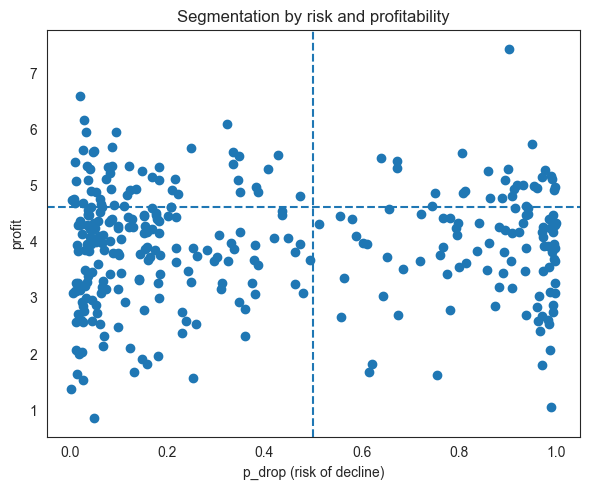

In [56]:
# Scatter plot: p_drop vs profit
plt.figure(figsize=(6, 5))
plt.scatter(df['p_drop'], df['прибыль'])
plt.axvline(risk_thr, linestyle='--')
plt.axhline(profit_thr, linestyle='--')
plt.xlabel("p_drop (risk of decline)")
plt.ylabel("profit")
plt.title("Segmentation by risk and profitability")
plt.tight_layout()
plt.show()


* **Scatter p_drop vs profit** shows a clear separation into quadrants; thresholds are the vertical line at **p_drop = 0.5** and the horizontal line at **profit = Q3**.


C:\Users\nursu\AppData\Local\Temp\ipykernel_27900\3122406170.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


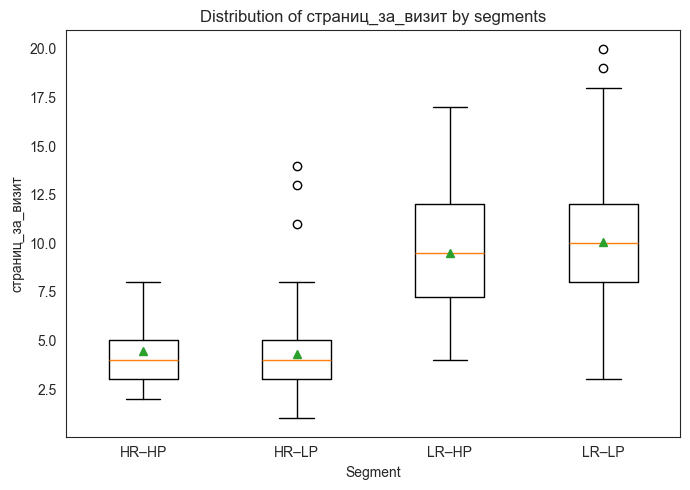

C:\Users\nursu\AppData\Local\Temp\ipykernel_27900\3122406170.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


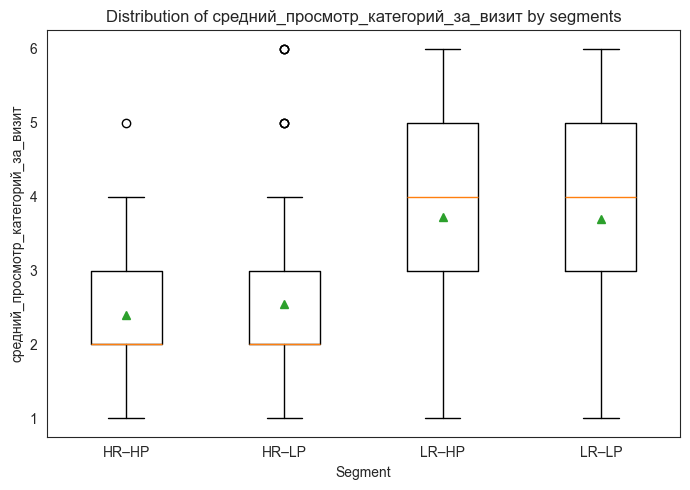

C:\Users\nursu\AppData\Local\Temp\ipykernel_27900\3122406170.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


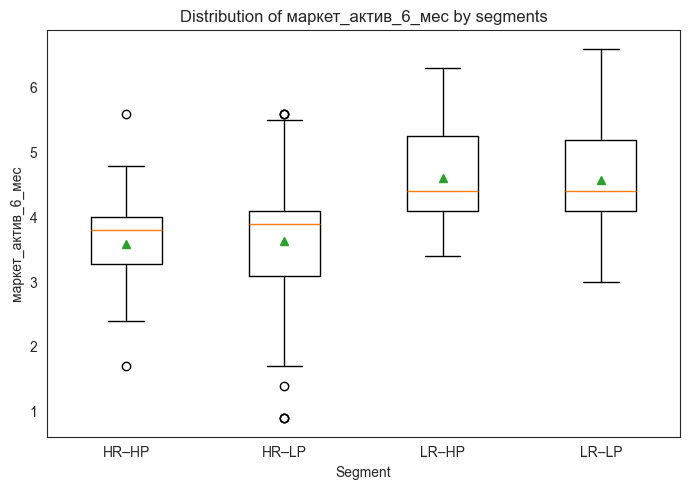

C:\Users\nursu\AppData\Local\Temp\ipykernel_27900\3122406170.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


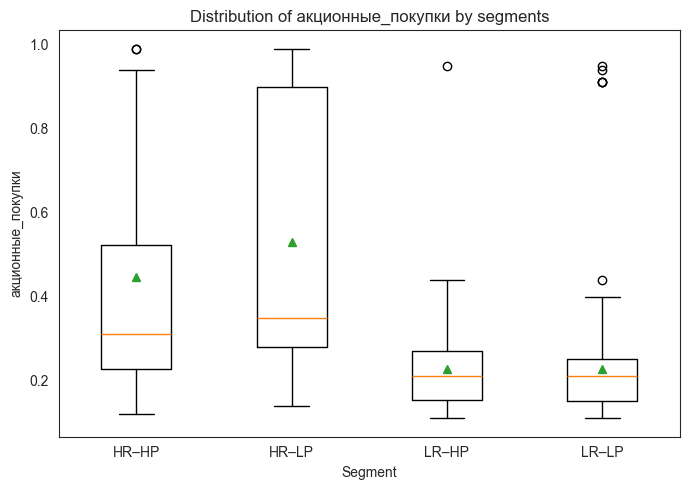

C:\Users\nursu\AppData\Local\Temp\ipykernel_27900\3122406170.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


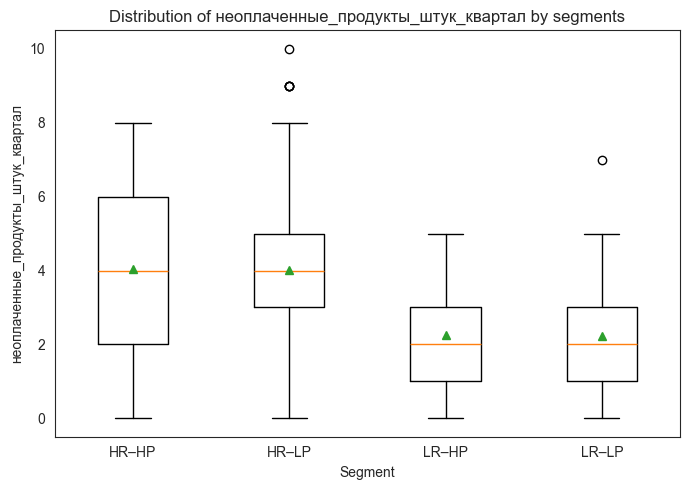

In [57]:
# Boxplots of key features by segment
key_features = [
    'страниц_за_визит',
    'средний_просмотр_категорий_за_визит',
    'маркет_актив_6_мес',
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал'
]
seg_order = ['HR–HP', 'HR–LP', 'LR–HP', 'LR–LP']

for feat in key_features:
    plt.figure(figsize=(7, 5))
    data = [df.loc[df['segment'] == seg, feat] for seg in seg_order]
    plt.boxplot(data, labels=seg_order, showmeans=True)
    plt.title(f"Distribution of {feat} by segments")
    plt.xlabel("Segment")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()

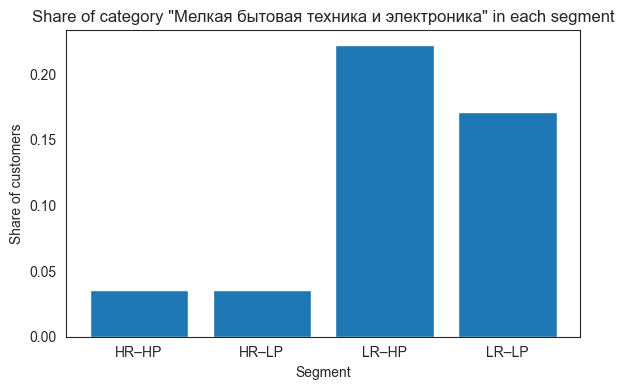

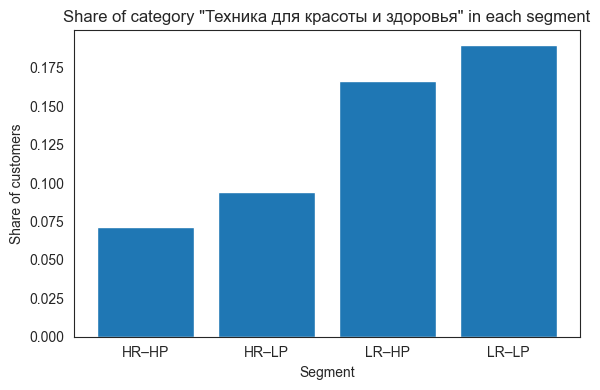

In [58]:
# Bar charts for significant categories
category_col = 'популярная_категория'
target_cats = [
    "Мелкая бытовая техника и электроника",
    "Техника для красоты и здоровья"
]


for cat in target_cats:
    shares = []
    for seg in seg_order:
        seg_df = df.loc[df['segment'] == seg]
        shares.append((seg_df[category_col] == cat).mean())

    plt.figure(figsize=(6, 4))
    plt.bar(seg_order, shares)
    plt.title(f'Share of category "{cat}" in each segment')
    plt.xlabel("Segment")
    plt.ylabel("Share of customers")
    plt.tight_layout()
    plt.show()


* **Boxplots of key features (by segment)**
  **HR segments** (especially **HR–HP**) show:

  * lower levels of **`страниц_за_визит`**, **`маркет_актив_6_мес`**, and **`средний_просмотр_категорий_за_визит`** compared to **LR–HP** (lower engagement);
  * higher **`акционные_покупки`**;
  * higher **`неоплаченные_продукты_штук_квартал`**.

* **Bar charts by category**
  For **“Small household appliances and electronics”** and **“Beauty and health equipment”**: a higher share corresponds to **lower risk**.

**These observations are consistent with the previously derived feature importances:** engagement and accumulated touchpoints protect against *“Decreased”* activity, while promotion dependence and abandoned carts are risk factors.


### Segment selection and activity growth plan

**Which segment we analyze in depth and why**

* **HR–HP (28 customers)** — the smallest segment, but its **high profitability** (**5.158**) combined with **high risk** (**0.879**) makes it a top priority: even a small improvement in retention can deliver a significant economic impact.

**Behavioral characteristics:**

* Low engagement (**pages per visit**, **categories viewed**, **marketing activity over 6 months**) despite high purchasing power.
* Increased sensitivity to promotions (**promotional purchases**).
* A high share of incomplete transactions (abandoned purchases).
* Weak purchasing activity in the categories **“Small household appliances and electronics”** and **“Beauty and health equipment.”**


**Recommendations to increase activity in the HR–HP segment**

1. **Increase engagement**

   * Personalized recommendations by category.
   * Curated thematic collections.
   * Push / email triggers when activity declines (drop in visits or views).

2. **Reduce dependence on promotions**

   * Gradually replace discounts with a bonus or cashback system.
   * Introduce a **premium program** with privileges (delivery, extended warranty, installation).

3. **Cart and service optimization**

   * Automated abandoned-cart reminders with recommendations and a bonus for accessories.
   * Improve service communications when errors or delays occur.

4. **Retention through value**

   * Educational newsletters (“how to use equipment more effectively”, “new brand releases”).
   * Post-purchase communication 7–10 days after purchase (accessories, consumables).


**Conclusions**

* **Selected segment:** **HR–HP** (28 customers, *p_drop_mean* = **0.88**, *profit_mean* = **5.16**).
* **Primary goal:** increase engagement and reduce churn **without sacrificing profitability**.

**Key actions:**

* Personalized collections in top categories.
* стимулиate repeat purchases without discounts.
* Automation of reminders and retention communications.
* Enhanced service quality.


## Overall Conclusion <a id="overall_conclusion"></a>

**Final Project Conclusion**

**Task**

Build a **classification model** to predict the target variable `покупательская_активность` (decline in customer activity) and, based on the predicted **risk of decline** and **customer profitability**, perform **customer segmentation** and propose measures to increase activity.

---

**Data and preprocessing**

The following tables were used: `market_file`, `market_money`, `market_time`, `money`. The following steps were performed:

* standardization of column names to `snake_case`, string cleaning (spaces/case);
* correction of typos in categorical fields and period values;
* checks for missing values and duplicates; data types validated and corrected;
* merging tables by `id`; creation of period-based features (revenue/time).

---

**Best model search**

* Train/test split with stratification by the target.
* Features prepared via **ColumnTransformer**:

  * categorical: **OneHotEncoder** (nominal), **OrdinalEncoder** (ordered `тип_сервиса`);
  * numerical: comparison of **StandardScaler / MinMaxScaler / passthrough**.
* Trained 4 models: **KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC**.
* Hyperparameter tuning via **RandomizedSearchCV**, k-fold CV, metric **ROC-AUC** (robust to class imbalance and evaluates probability ranking).

---

**Best model**

**LogisticRegression (penalty=L1, solver=liblinear, C=3)**.
Average **ROC-AUC ≈ 0.898** in cross-validation. L1 regularization helped select informative features and zero out weak ones.

---

**Customer segmentation (test set)**

For the test set, the probability of decline was computed as `p_drop = predict_proba`. Customers were split into quadrants:

* risk threshold: **p_drop ≥ 0.5 → HR**, otherwise **LR**;
* profit threshold: **Q3 → HP**, otherwise **LP**.

Segment results:

* **LR–HP** — 54 customers, *p_drop_mean* ≈ **0.149**, *profit_mean* ≈ **5.19**
* **HR–HP** — 28 customers, *p_drop_mean* ≈ **0.879**, *profit_mean* ≈ **5.16**
* **HR–LP** — 85 customers, *p_drop_mean* ≈ **0.862**, *profit_mean* ≈ **3.59**
* **LR–LP** — 158 customers, *p_drop_mean* ≈ **0.144**, *profit_mean* ≈ **3.52**

---

**Selected segment and proposals**

**Selected segment: HR–HP** (high risk, high profitability).
Rationale: a small group with a high economic impact from retention. Key patterns for these customers (from importances/plots): lower engagement (`pages_per_visit`, breadth of browsing), higher share of `promotional_purchases`, more abandoned carts; lower share of purchases in **“Small household appliances and electronics”** and **“Beauty and health equipment.”**

**Recommendations for HR–HP:**

1. **Increase engagement**: personalized recommendations for favorite categories, thematic collections, triggers when activity drops.
2. **Reduce discount dependence**: shift to bonuses/cashback, bundles (devices + accessories), extended warranty/installation.
3. **Remove funnel friction**: abandoned-cart reminder sequences, proactive support when service errors occur.
4. **Post-purchase scenarios**: emails on “how to get the most from your purchase,” upsell consumables/accessories within 7–30 days.

---

**Business impact**

* Predicting decline probability + segmentation enables **prioritization** of marketing efforts.
* Retaining **HR–HP** delivers the highest ROI.
* **HR–LP** can be tested via low-cost channels; **LR–LP** can be activated with soft, content-driven campaigns and cross-category collections.
